# Clickbait Classification from News



> Andrés Delicado









In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The data we are going to use is from the paper [Stop Clickbait: Detecting and Preventing Clickbaits](https://cse.iitkgp.ac.in/~abhijnan/papers/chakraborty_clickbait_asonam16.pdf) in Online News Media at 2016 IEEE/ACM International Conference on Advances in Social Networks Analysis and Mining (ASONAM

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import metrics
import spacy
from spacy.lang.en import English
import os
from termcolor import colored
import seaborn as sns
import matplotlib.pyplot as plt

%load_ext google.colab.data_table
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use('seaborn-whitegrid')
sns.set_style("darkgrid")
sns.color_palette("deep")
plt.rcParams['figure.figsize'] = [8, 6]

# Function to read text file
def read_text_file(file_path):
    with open(file_path, 'r') as file:
        content = file.read()
    return content

# File paths for your text files
text_file_path1 = '/content/drive/My Drive/FInal Proyect ML/clickbait_data'
text_file_path2 = '/content/drive/My Drive/FInal Proyect ML/non_clickbait_data'

# Read the text files
clickbait_str = read_text_file(text_file_path1)
non_clickbait_str = read_text_file(text_file_path2)

<ipython-input-2-47bc0706cf42>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


# 1. Preprocessing

### 1.1 Division into Sentences

First of all we divide our corpues into sentences using the function split, as we know that our sentences ar separated by *\n\n*

In [ ]:
non_clickbait_titles = non_clickbait_str.split('\n\n')
clickbait_titles = clickbait_str.split('\n\n')
# errase empty titles
non_clickbait_titles = [title.strip() for title in non_clickbait_titles if title.strip()]
clickbait_titles = [title.strip() for title in clickbait_titles if title.strip()]

#Verify the resulting list
print(non_clickbait_titles[:3])
print('\n---------------------')
print(clickbait_titles[:3])

["Bill Changing Credit Card Rules Is Sent to Obama With Gun Measure Included\nIn Hollywood, the Easy-Money Generation Toughens Up\n1700 runners still unaccounted for in UK's Lake District following flood", 'Yankees Pitchers Trade Fielding Drills for Putting Practice\nLarge earthquake rattles Indonesia; Seventh in two days', "Coldplay's new album hits stores worldwide this week"]

---------------------
['Should I Get Bings', 'Which TV Female Friend Group Do You Belong In', 'The New "Star Wars: The Force Awakens" Trailer Is Here To Give You Chills']


#### 1.2 Text Wrangling

If we inspect the titles, we can see that they contain womr tokens, such as enters (\n) or '' that we do not want to keep for our text vectorization task since they don't add much value for understanding and analyzing the text.

Additionally, there are English contractions (don´t) that we would like to transform into their base form (do not).

In [ ]:
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def wrangle_text(text):

    # Errase \n
    text = re.sub(r'\n', '', text)

    # Expandir contracciones
    text = contractions.fix(text)

    return text

clickbait_titles_wrangled=[]
non_clickbait_titles_wrangled=[]

for sentence in clickbait_titles:
  clickbait_titles_wrangled.append(wrangle_text(sentence))
for sentence in non_clickbait_titles:
  non_clickbait_titles_wrangled.append(wrangle_text(sentence))

#We can see that now we don´t have \n
non_clickbait_titles_wrangled[0]

"Bill Changing Credit Card Rules Is Sent to Obama With Gun Measure IncludedIn Hollywood, the Easy-Money Generation Toughens Up1700 runners still unaccounted for in UK's Lake District following flood"

#### 1.3 Tokenization

Tokenization is the process of segmenting a text into words,
referred to as **tokens**. This procedure will often also break off punctuation symbols (commas, periods, etc.), phrases, and other possible meaningful elements from the text, such as separate tokens. The list of tokens resulting from tokenization becomes the input for the homogenization stage.

In [ ]:
from nltk.tokenize import wordpunct_tokenize

def tokenization(sentence):
  return wordpunct_tokenize(sentence)

# Word tokenization
non_clickbait_tokenized = []
clickbait_tokenized = []
for sentence in non_clickbait_titles_wrangled:
  non_clickbait_tokenized.append(tokenization(sentence))
for sentence in clickbait_titles_wrangled:
  clickbait_tokenized.append(tokenization(sentence))

print(non_clickbait_tokenized[:2])

[['Bill', 'Changing', 'Credit', 'Card', 'Rules', 'Is', 'Sent', 'to', 'Obama', 'With', 'Gun', 'Measure', 'IncludedIn', 'Hollywood', ',', 'the', 'Easy', '-', 'Money', 'Generation', 'Toughens', 'Up1700', 'runners', 'still', 'unaccounted', 'for', 'in', 'UK', "'", 's', 'Lake', 'District', 'following', 'flood'], ['Yankees', 'Pitchers', 'Trade', 'Fielding', 'Drills', 'for', 'Putting', 'PracticeLarge', 'earthquake', 'rattles', 'Indonesia', ';', 'Seventh', 'in', 'two', 'days']]


#### 1.4 Homogenization, Lemmatization and Cleaning

We first did all this in three different steps (3 double loops for each title collection) but later we realiced that we could use the same loop to perform all of them, having now only 1 double loop for each title collection.
- Homogenization is the process that aims to collapse all semantically equivalent words into a unique representative one. The homogenization process comes from multiple words sharing the same lexeme. For example, ``develop``, ``development``, ``developing``, ``developed``, ``developer``, ``developmental``, and ``developmentally``, are set of words that share the same lexeme or root and, therefore, have a certain relationship of meaning.

- We are going to apply lemmatization instead off stemming as we know from the lectures that it is simply better.

- We are going to remove those words very common in the lenguage that does not provide useful semantic content

In [ ]:
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')
wnl = WordNetLemmatizer()

def cleaning_lemmatization(sentence):
  aux=[]
  for token in sentence:
    if token.isalnum():
      word=wnl.lemmatize(token.lower()) # We convert tokens to lowercase and errase non alfanumeric characters
      if word not in stopwords_en: #And check if it is not a stopword
        aux.append(word)
  return aux



non_clickbait_homogenized=[]
clickbait_homogenized=[]

for sentence in non_clickbait_tokenized:
  non_clickbait_homogenized.append(cleaning_lemmatization(sentence))

for sentence in clickbait_tokenized:
  clickbait_homogenized.append(cleaning_lemmatization(sentence))

#We see there is no comma
print(non_clickbait_homogenized[:2])

[['bill', 'changing', 'credit', 'card', 'rule', 'sent', 'obama', 'gun', 'measure', 'includedin', 'hollywood', 'easy', 'money', 'generation', 'toughens', 'up1700', 'runner', 'still', 'unaccounted', 'uk', 'lake', 'district', 'following', 'flood'], ['yankee', 'pitcher', 'trade', 'fielding', 'drill', 'putting', 'practicelarge', 'earthquake', 'rattle', 'indonesia', 'seventh', 'two', 'day']]


### 1.5 Preprocessing Pipeline

Instead of doing all this by hand for each document, we are going to create a preprocessing pipeline that does all this for us at a time.

In [ ]:
def preprocessing_pipeline(text):

    # Expand contractions
    wrangled_text = wrangle_text(text)

    #sentence tokenization
    tokenized_text=tokenization(wrangled_text)

    clean_text=cleaning_lemmatization(tokenized_text)

    return clean_text

non_clickbait_processed_titles=[]
clickbait_processed_titles=[]

for sentence in clickbait_titles:
  clickbait_processed_titles.append(preprocessing_pipeline(sentence))
for sentence in non_clickbait_titles:
  non_clickbait_processed_titles.append(preprocessing_pipeline(sentence))

#We can see we obtain the same result
non_clickbait_processed_titles[:1]

[['bill',
  'changing',
  'credit',
  'card',
  'rule',
  'sent',
  'obama',
  'gun',
  'measure',
  'includedin',
  'hollywood',
  'easy',
  'money',
  'generation',
  'toughens',
  'up1700',
  'runner',
  'still',
  'unaccounted',
  'uk',
  'lake',
  'district',
  'following',
  'flood']]

# 2. Creating the Database

First we are going to create a database by merging randomly both news entries, with a column indicating if they are clickbait or not         (1 = clickbait, 0 = non clickbait)

In [ ]:
# Create DataFrame
non_clickbait_df = pd.DataFrame({
    'text': non_clickbait_titles,
    'processed_text': non_clickbait_processed_titles,
    'is_clickbait': [0]*len(non_clickbait_processed_titles)
})

# Show the DataFrame
print(non_clickbait_df.head())


                                                text  \
0  Bill Changing Credit Card Rules Is Sent to Oba...   
1  Yankees Pitchers Trade Fielding Drills for Put...   
2  Coldplay's new album hits stores worldwide thi...   
3  U.N. Leader Presses Sri Lanka on Speeding Reli...   
4  White House Announces International Meetings t...   

                                      processed_text  is_clickbait  
0  [bill, changing, credit, card, rule, sent, oba...             0  
1  [yankee, pitcher, trade, fielding, drill, putt...             0  
2  [coldplay, new, album, hit, store, worldwide, ...             0  
3  [n, leader, press, sri, lanka, speeding, relie...             0  
4  [white, house, announces, international, meeti...             0  


In [ ]:
# Create the DataFrame
clickbait_df = pd.DataFrame({
    'text': clickbait_titles,
    'processed_text': clickbait_processed_titles,
    'is_clickbait': [1]*len(clickbait_processed_titles)
})

# shoe the DataFrame
print(clickbait_df.head())


                                                text  \
0                                 Should I Get Bings   
1      Which TV Female Friend Group Do You Belong In   
2  The New "Star Wars: The Force Awakens" Trailer...   
3  This Vine Of New York On "Celebrity Big Brothe...   
4  A Couple Did A Stunning Photo Shoot With Their...   

                                      processed_text  is_clickbait  
0                                       [get, bings]             1  
1                [tv, female, friend, group, belong]             1  
2  [new, star, war, force, awakens, trailer, give...             1  
3  [vine, new, york, celebrity, big, brother, fuc...             1  
4  [couple, stunning, photo, shoot, baby, learnin...             1  


In [ ]:
#Randomly shuffle the rows of the DataFrames
corpus_df = pd.concat([non_clickbait_df, clickbait_df], ignore_index=True).sample(frac=1).reset_index(drop=True)

display(corpus_df)

,text,processed_text,is_clickbait
0,Honey Boo Boo Walking Through Beverly Hills Is...,"[honey, boo, boo, walking, beverly, hill, hone...",1
1,If I Could Speak To My Mental Disorder,"[could, speak, mental, disorder]",1
2,Memphis Uses Size and Speed to Overpower Maryl...,"[memphis, us, size, speed, overpower, maryland...",0
3,How Futuristic Are You,[futuristic],1
4,"Welsh air route in difficulties, call for fund...","[welsh, air, route, difficulty, call, funding,...",0
...,...,...,...
25995,"Mumbai Is Sending Powerful Messages Of Love, S...","[mumbai, sending, powerful, message, love, sup...",1
25996,South African lawyer and anti-apartheid leader...,"[south, african, lawyer, anti, apartheid, lead...",0
25997,Residents fear environmental hazard on site of...,"[resident, fear, environmental, hazard, site, ...",0
25998,A Little Girl Asked Her Mom To Be Friends With...,"[little, girl, asked, mom, friend, dad, melt, ...",1


In [ ]:
del non_clickbait_df
del clickbait_df

# 3. Vectorization

### 3.1 Gensim corpus

In [ ]:
# We extract the processed lemmas to a list
corpus = corpus_df['processed_text'].tolist()

print(colored('Number of documents in corpus: '+str(len(corpus)), 'green'))
print(colored('\n============= First title =============', 'blue'))
print(corpus[0])


Number of documents in corpus: 26000

============= First title =============
['honey', 'boo', 'boo', 'walking', 'beverly', 'hill', 'honey', 'boo', 'boo', 'thing', 'ever']


Average number of tokens per review: 7.62


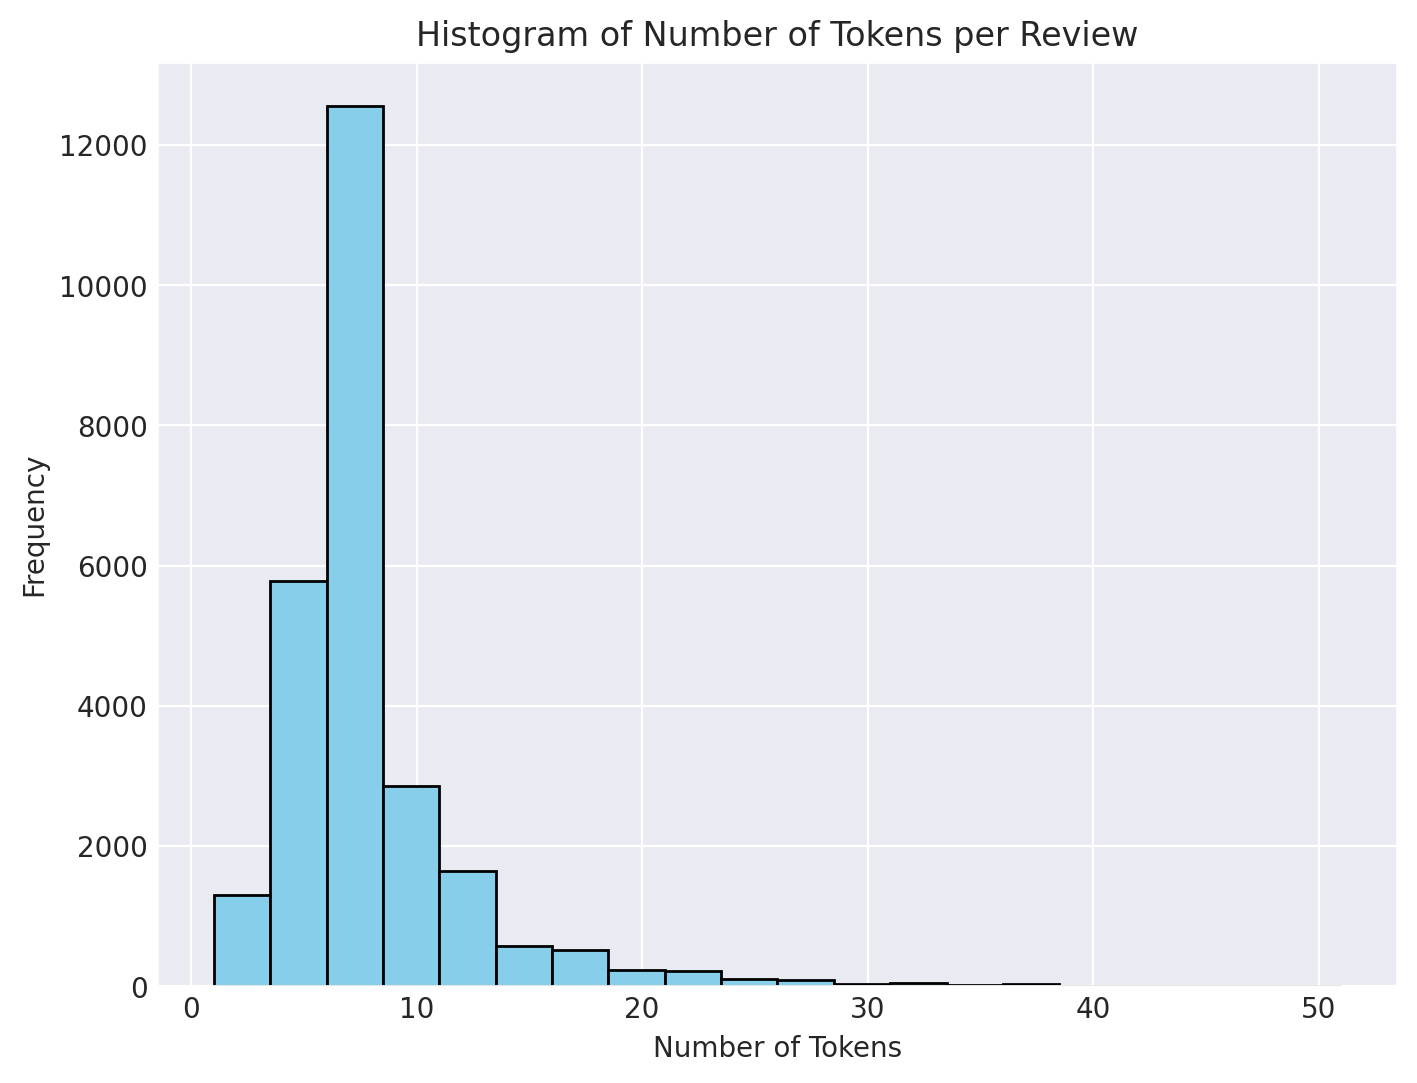

In [ ]:
import matplotlib.pyplot as plt

# Compute the average number of tokens per review
num_tokens_per_review = [len(review) for review in corpus]
average_tokens_per_review = sum(num_tokens_per_review) / len(num_tokens_per_review)

print("Average number of tokens per review:", round(average_tokens_per_review, 2))

plt.hist(num_tokens_per_review, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Tokens')
plt.ylabel('Frequency')
plt.title('Histogram of Number of Tokens per Review')
plt.show()


### 3.2 N-grams detection

In order to explore further relations and allow the model understand better our data, we are going to look for related words with 2-gram detection.

In [ ]:
from gensim.models.phrases import Phrases

phrase_model = Phrases(corpus, min_count=2, threshold=20)

print(colored('\n============= First review in corpus =============', 'blue'))
print(corpus[0])
corpus = [el for el in phrase_model[corpus]] # We populate corpus again
print(colored('\n============= First review after N-gram replacement =============', 'blue'))
print(corpus[0])


============= First review in corpus =============
['honey', 'boo', 'boo', 'walking', 'beverly', 'hill', 'honey', 'boo', 'boo', 'thing', 'ever']

============= First review after N-gram replacement =============
['honey_boo', 'boo', 'walking', 'beverly_hill', 'honey_boo', 'boo', 'thing_ever']


We save our clean text for later use

In [ ]:
corpus_df['processed_text'] = corpus
ruta_directorio='/content/drive/My Drive/FInal Proyect ML/'
with open(ruta_directorio +"imdb_titles_clean.txt", 'w', encoding='utf-8') as fout:
  for el in corpus_df['processed_text'].values.tolist():
    fout.write(' '.join(el) + '\n')

### 3.3. Gensim dictionary

As a first step for vectorizing documents, we need to create a dictionary containing all tokens in our text corpus and assign an integer identifier to each one of them.

The following code fragment generates such a dictionary and shows the first tokens in the dictionary.

In [ ]:
from gensim.corpora import Dictionary

# Create dictionary of tokens
D = Dictionary(corpus)
n_tokens = len(D)

print('The positive dictionary contains', n_tokens, 'terms')
print('First terms in the dictionary:')
for n in range(10):
    print(str(n), ':', D[n])

The positive dictionary contains 27942 terms
First terms in the dictionary:
0 : beverly_hill
1 : boo
2 : honey_boo
3 : thing_ever
4 : walking
5 : could
6 : disorder
7 : mental
8 : speak
9 : flood


DataFrame sorted by ndocs:
      token  ndocs
368   thing    917
48   people    899
311     new    790
734    time    708
49       17    704

Number of tokens that appear in exactly one document: 14567

Most common token: thing
Least common token: tracee


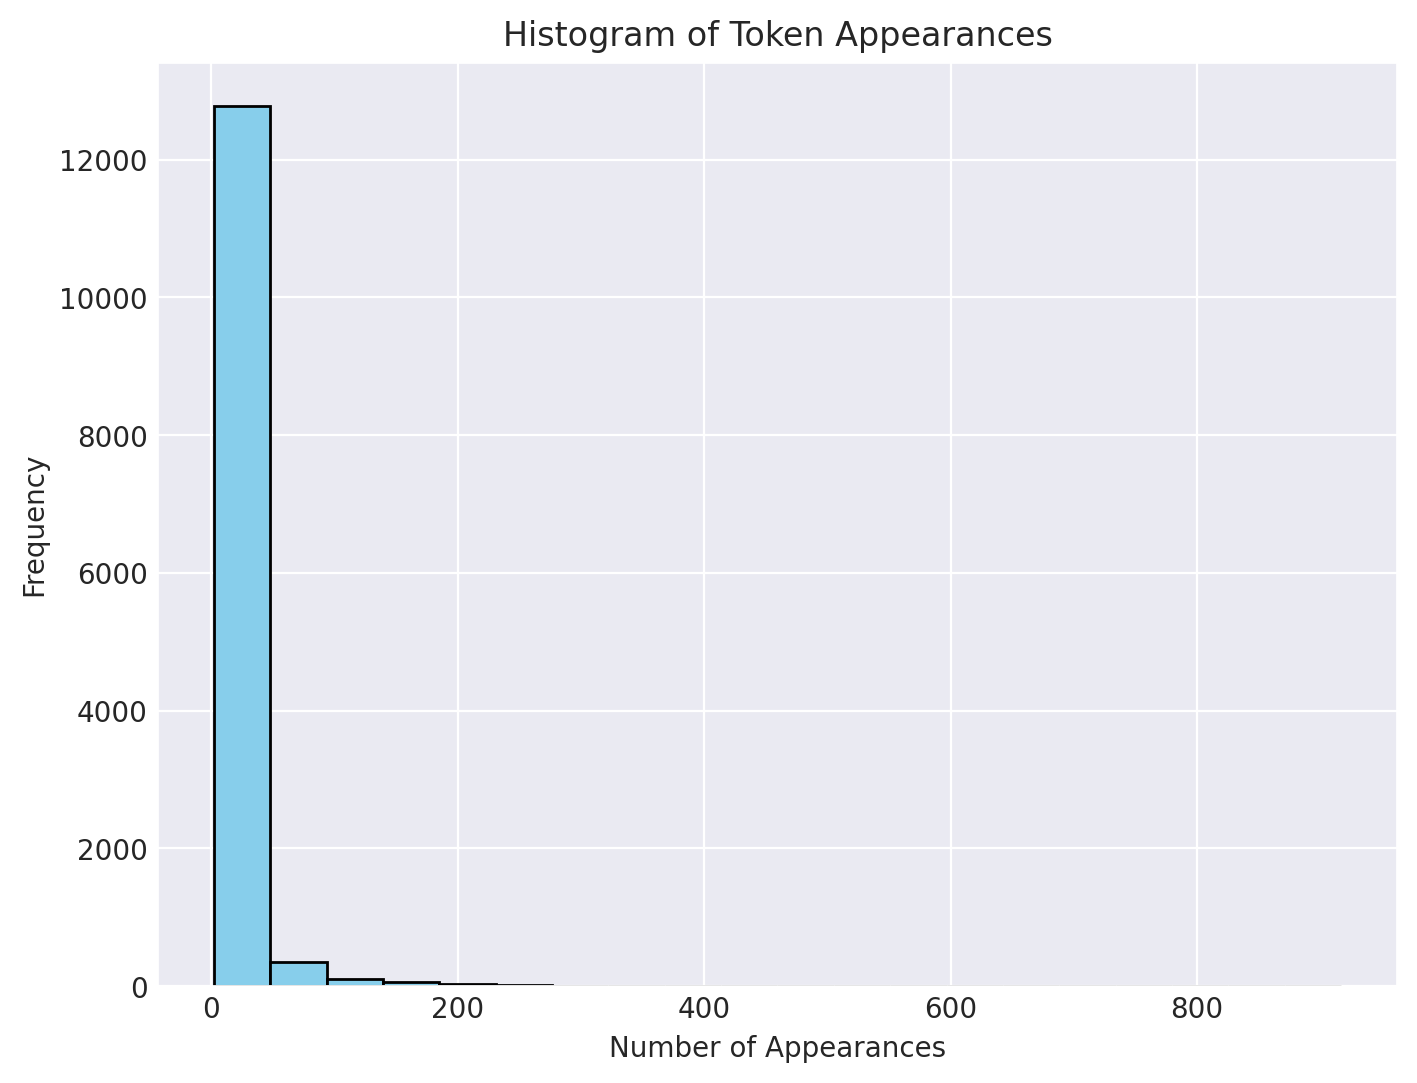

In [ ]:
# Get the number of documents where each token appears
tokens_ndocs = [(D[id], ndocs) for id, ndocs in D.dfs.items()]

# Create a DataFrame from the results
df_tokens_ndocs = pd.DataFrame(tokens_ndocs, columns=['token', 'ndocs'])

# Sort the DataFrame by the ndocs column
df_tokens_ndocs.sort_values(by='ndocs', ascending=False, inplace=True)

# Print the sorted DataFrame
print("DataFrame sorted by ndocs:")
print(df_tokens_ndocs.head())

# Count the number of tokens that appear in exactly one document
tokens_appear_once = df_tokens_ndocs[df_tokens_ndocs['ndocs'] == 1]
num_tokens_appear_once = len(tokens_appear_once)
print("\nNumber of tokens that appear in exactly one document:", num_tokens_appear_once)

# Remove tokens that appear in exactly one document from the DataFrame
df_tokens_ndocs = df_tokens_ndocs[df_tokens_ndocs['ndocs'] > 1]

# Calculate the most and least common tokens in terms of occurrence in documents
most_common_token = df_tokens_ndocs.iloc[0]['token']
least_common_token = df_tokens_ndocs.iloc[-1]['token']
print("\nMost common token:", most_common_token)
print("Least common token:", least_common_token)

# Plot a histogram of the number of appearances of the tokens
plt.hist(df_tokens_ndocs['ndocs'], bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Number of Appearances')
plt.ylabel('Frequency')
plt.title('Histogram of Token Appearances')
plt.show()

In [ ]:
no_below = 4 #Minimum number of documents to keep a term in the dictionary
no_above = .80 #Maximum proportion of documents in which a term can appear to be kept in the dictionary

D.filter_extremes(no_below=no_below,no_above=no_above)
n_tokens = len(D)

#We see that the dictionary size has been considerably reduced with respect to the original vocabulary.
print('The dictionary contains', n_tokens, 'terms')

The dictionary contains 7728 terms


#### 3.3.2 Computational efficiency

As explained in a deeper level at the report, the computation of the Gensim Dictionary requires all the corpus to be stored in RAM. For this dataset that not a problem, but for larger datasets it can be prohibitive. There is a way to solve this by saving the corpus in a text file and read it. The following code was taken from the *Text_Vectorization_I_students.ipynb* script of Jerónimo Arenas-García, Lorena Calvo-Bartolomé and Jesús Cid-Suero and can be found [here](https://aulaglobal.uc3m.es/course/view.php?id=166694#section-2) for more detail.

In [ ]:
class IterableCorpus_fromfile:
    def __init__(self, filename):
        self.__filename = filename
    def __iter__(self):
        for line in open(ruta_directorio + self.__filename):
            # assume there's one document per line, tokens separated by whitespace
            yield line.lower().split()

MyIterCorpus = IterableCorpus_fromfile('imdb_titles_clean.txt')
newD = Dictionary(MyIterCorpus)
no_below = 4
no_above = .80
newD.filter_extremes(no_below=no_below,no_above=no_above)

print('Number of documents processed:', newD.num_docs)
print('Number of elements in dictionary:', len(newD))

Number of documents processed: 26000
Number of elements in dictionary: 7728


Wee see that we have obtained the same results

## 3.4 Classical BoW vs TF-IDF representation

### 3.4 Bag-Of-Words (BoW)

Next, let us create a numerical version of our corpus using the `doc2bow` method.

In [ ]:
reviews_bow = [D.doc2bow(doc) for doc in corpus]

n_review = 1000
print(colored('============= Review (lemmas) =============', 'blue'))
print(' '.join(corpus[n_review]))

print(colored('\n============= Sparse vector representation =============', 'blue'))
print(reviews_bow[n_review])

print(colored('\n============= Word counts for the titles =============', 'blue'))
print(list(map(lambda x: (D[x[0]], x[1]), reviews_bow[n_review])))

============= Review (lemmas) =============
nuclear arm agreement reached north_korea

============= Sparse vector representation =============
[(388, 1), (1549, 1), (2282, 1), (2788, 1), (2789, 1)]

============= Word counts for the titles =============
[('arm', 1), ('nuclear', 1), ('agreement', 1), ('north_korea', 1), ('reached', 1)]


Alternatively, we can do it directly with the CountVectorizer function of sklearn

In [ ]:
# First, we need all the lemmas in a single list
all_lemmas_phrases = []

# Iterate over each row of the DataFrame
for index, row in corpus_df.iterrows():
    all_lemmas_words = []
    for lemma in row['processed_text']:
        all_lemmas_words.append(lemma)
    # Join the lemmas of the row to form a phrase
    phrase = ' '.join(all_lemmas_words)
    # Add the phrase to the list
    all_lemmas_phrases.append(phrase)

print(all_lemmas_phrases[0])


honey_boo boo walking beverly_hill honey_boo boo thing_ever


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# Bow Representation (Bag of Words)
bow_vectorizer = CountVectorizer(stop_words='english')
bow_matrix = bow_vectorizer.fit_transform(all_lemmas_phrases)

print("Bag of Words (BoW) Matrix:")
print(bow_matrix)

Bag of Words (BoW) Matrix:
  (0, 11943)	2
  (0, 3367)	2
  (0, 26689)	1
  (0, 2879)	1
  (0, 24831)	1
  (1, 23190)	1
  (1, 15708)	1
  (1, 7434)	1
  (2, 15691)	1
  (2, 22665)	1
  (2, 23218)	1
  (2, 17743)	1
  (2, 15391)	1
  (2, 21772)	1
  (2, 9659)	1
  (2, 19788)	1
  (2, 24068)	1
  (3, 10223)	1
  (4, 26988)	1
  (4, 1139)	1
  (4, 21268)	1
  (4, 7262)	1
  (4, 10171)	1
  (5, 16843)	1
  (5, 7325)	1
  :	:
  (25996, 1585)	1
  (25996, 14209)	1
  (25996, 584)	1
  (25996, 1629)	1
  (25996, 21794)	1
  (25997, 9232)	1
  (25997, 22647)	1
  (25997, 16845)	1
  (25997, 20688)	1
  (25997, 8534)	1
  (25997, 11500)	1
  (25997, 18034)	1
  (25997, 3806)	1
  (25998, 1885)	1
  (25998, 6499)	1
  (25998, 10072)	1
  (25998, 16206)	1
  (25998, 14651)	1
  (25998, 15659)	1
  (25999, 121)	1
  (25999, 260)	1
  (25999, 23043)	1
  (25999, 14981)	1
  (25999, 18952)	1
  (25999, 16065)	1


### 3.4 TF-IDF representation

We can do it numerically using the dictionary

In [ ]:
from gensim.models import TfidfModel

tfidf = TfidfModel(reviews_bow)

reviews_tfidf = tfidf[reviews_bow]
n_project = 1000
print(colored('============= TFIDF representation for the project =============', 'blue'))
print(reviews_tfidf[n_review])

print(colored('\n============= TFIDF applying the transformation only to the document =============', 'blue'))
print(tfidf[reviews_bow[n_review]])

============= TFIDF representation for the project =============
[(388, 0.4372486214637749), (1549, 0.40276111188983615), (2282, 0.4498350633922127), (2788, 0.3964208138563837), (2789, 0.5358134786114078)]

============= TFIDF applying the transformation only to the document =============
[(388, 0.4372486214637749), (1549, 0.40276111188983615), (2282, 0.4498350633922127), (2788, 0.3964208138563837), (2789, 0.5358134786114078)]


As in the BoW representation, there is also a sklearn library for this

In [ ]:
from sklearn.feature_extraction.text import  TfidfVectorizer

# Representación TF-IDF (Term Frequency-Inverse Document Frequency)
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf_vectorizer.fit_transform(all_lemmas_phrases)

print('\n -----------------------------------------------------------------------')
print("\nTF-IDF Matrix:")
print(tfidf_matrix)


 -----------------------------------------------------------------------

TF-IDF Matrix:
  (0, 24831)	0.2351675354484046
  (0, 2879)	0.30445116360221364
  (0, 26689)	0.28947770416870217
  (0, 3367)	0.597285461867068
  (0, 11943)	0.6414502748333982
  (1, 7434)	0.5807252248490586
  (1, 15708)	0.6187846814659795
  (1, 23190)	0.5290214846365471
  (2, 24068)	0.3304204185505394
  (2, 19788)	0.32068181817160024
  (2, 9659)	0.2927601779232767
  (2, 21772)	0.24147150639404244
  (2, 15391)	0.4058257243445616
  (2, 17743)	0.37896581247465266
  (2, 23218)	0.3277468991310498
  (2, 22665)	0.322896744526959
  (2, 15691)	0.3521059006047438
  (3, 10223)	1.0
  (4, 10171)	0.5006959332763663
  (4, 7262)	0.4799369231449859
  (4, 21268)	0.4537836633771983
  (4, 1139)	0.3499464917647631
  (4, 26988)	0.43655695156088903
  (5, 1152)	0.3913363814044622
  (5, 581)	0.3913363814044622
  :	:
  (25996, 1585)	0.2897285383479035
  (25996, 23110)	0.32869641231666474
  (25996, 11441)	0.3451068162017134
  (25996, 14236)

### 3.5 Clickbait News Classification with BoW and TF-IDF representations

In [ ]:
Y=corpus_df['is_clickbait'].to_list() #target variable

Since we have carried out the vectorization with Gensim,  we have to convert our vector representation into NumPy arrays so we can use Sklearn's classifiers. To do this we use the following libraries:

In [ ]:
from gensim.matutils import corpus2dense, corpus2csc

n_tokens = len(D)
num_docs = len(reviews_tfidf)

# Convert BoW representacion
corpus_bow_dense = corpus2dense(reviews_bow, num_terms=n_tokens, num_docs=num_docs).T
corpus_bow_sparse = corpus2csc(reviews_bow, num_terms=n_tokens, num_docs=num_docs).T

# Convert TFIDF representacion
corpus_tfidf_dense = corpus2dense(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T
corpus_tfidf_sparse = corpus2csc(reviews_tfidf, num_terms=n_tokens, num_docs=num_docs).T

#### 3.5.1 BoW classification

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
import numpy as np
from sklearn.metrics import accuracy_score

# Convert the BoW representation to a csr_matrix sparse matrix
corpus_bow_sparse = csr_matrix(corpus_bow_sparse)

# Split the BoW representation into training and test sets
X_train, X_test, y_train, y_test = train_test_split(corpus_bow_sparse, Y, test_size=0.3, random_state=42)

# Define the parameters to search
param_grid = {'C': [2.34, 2.38, 2.43], 'kernel': ['rbf', 'poly']}

# Instantiate the SVM classifier
svm = SVC()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

# Train GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best estimator
best_svm = grid_search.best_estimator_

# Predict test labels
y_pred = best_svm.predict(X_test)

# Calculate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)


Best parameters: {'C': 2.34, 'kernel': 'rbf'}
Accuracy: 0.9598717948717949
R2 score: 0.8296542897513968


#### 3.5.2 TF-IDF classification

In [ ]:
from sklearn.metrics import r2_score
from scipy.sparse import csr_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Convert the BoW representation to a csr_matrix sparse matrix
corpus_tfidf_sparse = csr_matrix(corpus_tfidf_sparse)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(corpus_tfidf_sparse, Y, test_size=0.3, random_state=42)

# Define the parameters to search
param_grid = {'C': [0.85, 0.88, 0.92], 'kernel': ['rbf', 'poly']}

# Instantiate the SVM classifier
svm = SVC()

# Instantiate GridSearchCV
grid_search = GridSearchCV(estimator=svm, param_grid=param_grid, cv=5)

# Train GridSearchCV
grid_search.fit(X_train, y_train)

# Get the best hyperparameters
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Get the best estimator
best_svm = grid_search.best_estimator_

# Create a TfidfVectorizer object to convert titles into TF-IDF representation
tfidf_vectorizer = TfidfVectorizer()

# Predict test labels
y_pred = best_svm.predict(X_test)

# Calculate the model accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Calculate the R2 score
r2 = r2_score(y_test, y_pred)
print("R2 score:", r2)

Best parameters: {'C': 0.88, 'kernel': 'rbf'}
Accuracy: 0.9707692307692307
R2 score: 0.8759143069115606


We see that the performance of both methods is quite good and surprisingly similar. With the TF-IDF representation we obtain a 97% accuracy (only 1% more than with BoW), so we prefer that representation as the computational cost is similar.

## 3.5 Word2vec/Glove based representation vs Doc2Vec vectorization

### 3.5.1 Word2vec with Gensim

In [ ]:
# Get the vocabulary list
vocab = list(D.token2id.keys())

print(vocab[0:10])

['beverly_hill', 'boo', 'thing_ever', 'walking', 'could', 'disorder', 'mental', 'speak', 'flood', 'memphis']


As for the Gensime dictionary, this other [script](https://colab.research.google.com/drive/1CKLyYwmysIqnwspJHKYPYNWwrDh_ruIf?authuser=2#scrollTo=RRzzl3bhJ4mk) from Lorena Calvo-Bartolomé provided an efficient wat for extracting the sentences, using the previously created text file.

In [ ]:
%%time
from gensim.models import Word2Vec

class IterableSentence_fromfile(object):
    def __init__(self, filename):
        self.__filename = filename

    def __iter__(self):
        for line in open(ruta_directorio +self.__filename):
            # assume there's one sentence per line, tokens separated by whitespace
            yield line.split()

sentences = IterableSentence_fromfile("imdb_titles_clean.txt") # a memory-friendly iterator

model_w2v = Word2Vec(sentences, vector_size=200, window=5, sg=1, seed=42)

print('Word2Vec model trained!')

Word2Vec model trained!
CPU times: user 8 s, sys: 58.8 ms, total: 8.05 s
Wall time: 4.65 s


We can see the embedding for each word

In [ ]:
print(colored('\n============= Word2Vec vocabulary =============', 'blue'))
words = list(model_w2v.wv.key_to_index)
print(words[0:50])
print(colored('\n============= Embedding of the first word =============', 'blue'))
print(model_w2v.wv[words[0]])


============= Word2Vec vocabulary =============
['thing', 'people', 'new', 'time', '17', '21', 'make', 'know', '19', 'u', 'actually', 'wa', '2015', 'woman', 'say', 'life', '15', 'get', 'best', 'year', 'way', '23', '18', 'one', 'ha', 'first', 'day', 'sign', 'need', 'win', 'like', 'love', 'photo', 'killed', 'two', '16', 'movie', 'show', '13', 'uk', 'world', 'take', '22', 'character', 'dead', 'would', 'want', 'dog', '27', 'look']

============= Embedding of the first word =============
[ 0.25190622  0.2508068  -0.12082669  0.160615   -0.03106035  0.22917321
 -0.1305219   0.3842211  -0.04053398 -0.10488039 -0.06503982  0.07308504
  0.20998237  0.20060931  0.05411122 -0.22811781 -0.15889382 -0.3890166
  0.03158344  0.02343195  0.09161587  0.00742965 -0.0629736   0.04864625
  0.23751475  0.3165038  -0.07093694  0.44070795 -0.13218799 -0.37282816
  0.15417464 -0.17472905 -0.3838177  -0.09037983 -0.06824447  0.10107514
  0.29057235 -0.18968512 -0.3166919  -0.02194671 -0.0289923  -0.22347383
 

Also, since we are not going to keep with the training, we do not need the full model state anymore. Hence, we can store the words and their trained embeddings and load them back, as ``KeyedVectors``, which is essentially a mapping between keys and vectors. This results in a much smaller and faster object that can be mapped for lightning-fast loading and sharing the vectors in RAM between processes.

In [ ]:
from gensim.models import KeyedVectors

# Store just the words + their trained embeddings.
word_vectors = model_w2v.wv
word_vectors.save("model_w2v_imbd_sampling.wordvectors")
model_w2v_vector_size=model_w2v.vector_size

# Load back with memory-mapping = read-only, shared across processes.
wv = KeyedVectors.load("model_w2v_imbd_sampling.wordvectors", mmap='r')

In [ ]:
import gc

del model_w2v
gc.collect()

0

In [ ]:
# to see the performance
wv.most_similar(positive="president")

[('government', 0.9954544305801392),
 ('iraq', 0.9952826499938965),
 ('military', 0.9942879676818848),
 ('attack', 0.993276059627533),
 ('election', 0.9932229518890381),
 ('strike', 0.9932226538658142),
 ('former', 0.9931358098983765),
 ('protest', 0.9929183721542358),
 ('court', 0.9923380017280579),
 ('leader', 0.991990864276886)]

#### 3.5.1.1 Clickbait Classification Word2Vec embeddings

In [ ]:
def get_vocabulary_coverage(model, gensim_dict):
    total_words = sum(gensim_dict.dfs.values())
    covered_words = 0
    oov_words = 0

    for word, idx in gensim_dict.token2id.items():
        if word in model:
            covered_words += gensim_dict.dfs[idx]
        else:
            oov_words += gensim_dict.dfs[idx]

    coverage = covered_words / total_words
    return coverage

# Using the function to calculate coverage
w2v_coverage = get_vocabulary_coverage(wv, D)
print(f"Word2Vec model coverage on the IMDB vocabulary: {w2v_coverage * 100:.2f}%")

Word2Vec model coverage on the IMDB vocabulary: 95.92%


Creating the embbeding matrix

In [ ]:
import numpy as np

def get_title_vector(model, title):
    title_vector = np.zeros(model.vector_size)
    count = 0
    for word in title:
        if word in model:
            title_vector += model[word]
            count += 1
    if count != 0:
        title_vector /= count
    return title_vector

# Calculate embedding vectors for each review and save them in a matrix
w2v_embedding_matrix = np.zeros((len(corpus_df), model_w2v_vector_size))
for i, title in enumerate(corpus_df['text']):
    w2v_embedding_matrix[i] = get_title_vector(wv, title.split())


print("Shape of the embedding matrix:", w2v_embedding_matrix.shape)


Shape of the embedding matrix: (26000, 200)


Finally we use a SVC, tuned with a GridSearch, for making the predictions

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

# Splitting the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(w2v_embedding_matrix, Y, test_size=0.3, random_state=42)

# Set the parameters for grid search
param_grid = {'C':  [5,10,20,40],
              'kernel': ['linear', 'rbf']}

# Initialize the SVM classifier
svm = SVC()

# Perform grid search
grid_search = GridSearchCV(svm, param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Initialize SVM classifier with best parameters
svm_best = SVC(C=best_params['C'], kernel=best_params['kernel'])
svm_best.fit(X_train, y_train)

# Evaluate the performance of the classifier
y_pred = svm_best.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print("Best parameters:", best_params)
print("Accuracy on test set:", accuracy)


Best parameters: {'C': 40, 'kernel': 'rbf'}
Accuracy on test set: 0.9664102564102565


### 3.5.2 Glove with Gensim

For Glove we also need a pre-trained model

In [ ]:
from gensim import downloader

print(colored('\n============= Available pre-trained models in Gensim =============', 'blue'))
print(list(downloader.info()['models'].keys()))


============= Available pre-trained models in Gensim =============
['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
glove = downloader.load('glove-wiki-gigaword-50')

print(f"The dictionary size is {glove.vectors.shape[0]}.\n\
        Each embedding has a dimension of {glove.vectors.shape[1]}")

The dictionary size is 400000.
        Each embedding has a dimension of 50


We have the same model with different embeding sizes (50,100,200,300) but surprisingly we have seen that the accuracy we obtain is almost the same one with the 50 or with the 200 embedding size. So, for computational resons, we have decided to use the 50 embedding size model.

#### 3.5.2.1 Clickbait Classification with ad-hoc trained glove embeddings

In [ ]:
# Calculate vocabulary coverage for GloVe embeddings
glove_coverage = get_vocabulary_coverage(glove, D)

print(f"GloVe model coverage on the IMDB vocabulary: {glove_coverage * 100:.2f}%")
print(f"Word2Vec model coverage on the IMDB vocabulary: {w2v_coverage * 100:.2f}%")

GloVe model coverage on the IMDB vocabulary: 87.70%
Word2Vec model coverage on the IMDB vocabulary: 95.92%


In [ ]:
# Calculate embedding vectors for each title using GloVe embeddings
glove_embedding_matrix = np.zeros((len(corpus_df), glove.vector_size))
for i, review in enumerate(corpus_df['text']):
    review_tokens = review.split()
    review_vectors = [glove[token] for token in review_tokens if token in glove]
    if review_vectors:
        glove_embedding_matrix[i] = np.mean(review_vectors, axis=0)
del glove

In [ ]:
# Splitting the data into training and test sets
X_train_glove, X_test_glove, y_train_glove, y_test_glove = train_test_split(glove_embedding_matrix, Y, test_size=0.3, random_state=42)

param_grid = {'C':  [3.8,3.9,4.05],
              'kernel': ['linear', 'rbf']}
# Perform grid search for SVM classifier with GloVe embeddings
grid_search_glove = GridSearchCV(svm, param_grid, cv=5)
grid_search_glove.fit(X_train_glove, y_train_glove)

# Get the best parameters for SVM classifier with GloVe embeddings
best_params_glove = grid_search_glove.best_params_

# Initialize SVM classifier with best parameters
svm_best_glove = SVC(C=best_params_glove['C'], kernel=best_params_glove['kernel'])
svm_best_glove.fit(X_train_glove, y_train_glove)

# Evaluate the performance of the classifier with GloVe embeddings
y_pred_glove = svm_best_glove.predict(X_test_glove)
accuracy_glove = accuracy_score(y_test_glove, y_pred_glove)

print("Best parameters with GloVe embeddings:", best_params_glove)
print("Accuracy on test set with GloVe embeddings:", accuracy_glove)


Best parameters with GloVe embeddings: {'C': 3.8, 'kernel': 'rbf'}
Accuracy on test set with GloVe embeddings: 0.9969230769230769


The accuracy is almost of the 100%, so it is the best embedding representation till the moment.

## Doc2Vec with Gensim

In [ ]:
from gensim.models.doc2vec import Doc2Vec
from gensim.models.doc2vec import TaggedDocument

from gensim.models import Phrases
from gensim.models.phrases import Phraser

import gensim.downloader as api

# Tagg our documents
tagged_data = [TaggedDocument(words=doc.split(), tags=[str(i)]) for i, doc in enumerate(all_lemmas_phrases)]

max_epochs = 20
vec_size = 200
alpha = 0.025

d2v_model = Doc2Vec(tagged_data,vector_size=vec_size, alpha=alpha, window=5, min_alpha=0.00025, min_count=1, dm=0, epochs=30) # 0=PV-DBOW, 1=PV-DM
d2v_model.build_vocab(tagged_data, update=True)

d2v_model.train(tagged_data, total_examples=d2v_model.corpus_count, epochs=d2v_model.epochs)

# embedding matrix
d2v_embedding_matrix = np.zeros((len(all_lemmas_phrases), vec_size))
for i in range(len(all_lemmas_phrases)):
    d2v_embedding_matrix[i] = d2v_model.dv[str(i)]

In [ ]:
#Let’s make an inference from the model in the numerical format.

print(d2v_model.infer_vector(['president', 'Top', 'Mexican', 'Drug']))

[-1.35762885e-01 -2.80467439e-02 -1.04320079e-01  2.01139852e-01
  1.17954418e-01  1.39649197e-01  2.27537360e-02 -1.67959332e-02
  9.39635113e-02 -1.74385190e-01 -1.20368361e-01  4.53426018e-02
  8.46963376e-02 -4.21367474e-02 -2.27562904e-01  1.16180424e-02
 -6.87878430e-02  4.03495179e-03 -2.34240964e-02  5.05963266e-02
  5.71514620e-03  1.51063800e-01 -3.21161561e-02 -1.51364475e-01
 -4.99469042e-02  2.52944767e-01  2.00276580e-02 -1.27435163e-01
  4.92849424e-02 -1.03548005e-01  1.43749441e-03  9.73875448e-02
  4.66313884e-02  2.29781970e-01 -2.64784694e-01  7.59831294e-02
  5.79914190e-02  1.02405615e-01 -4.68601426e-03  2.67035491e-03
  7.51873180e-02  1.09997004e-01  1.20288692e-01 -8.65198821e-02
  2.89385673e-02  7.98321515e-02 -3.34004760e-02 -1.65568069e-01
 -4.18075807e-02  2.18004789e-02  1.51309654e-01  1.49959337e-03
  2.04764560e-01 -7.48683745e-03 -2.68856674e-01  1.54045755e-02
 -7.58087561e-02  8.48917887e-02  5.45420125e-02  7.14453235e-02
  9.19175670e-02 -1.03711

In [ ]:
del d2v_model

In [ ]:
# Splitting the data into training and test sets
X_train_d2v, X_test_d2v, y_train_d2v, y_test_d2v = train_test_split(d2v_embedding_matrix, Y, test_size=0.3, random_state=42)

param_grid = {'C':  [5.25,5.3,5.4],
              'kernel': ['linear', 'rbf']}
# Perform grid search for SVM classifier with GloVe embeddings
grid_search_d2v = GridSearchCV(svm, param_grid, cv=5)
grid_search_d2v.fit(X_train_d2v, y_train_d2v)

# Get the best parameters for SVM classifier with GloVe embeddings
best_params_d2v = grid_search_d2v.best_params_

# Initialize SVM classifier with best parameters
svm_best_d2v = SVC(C=best_params_d2v['C'], kernel=best_params_d2v['kernel'])
svm_best_d2v.fit(X_train_d2v, y_train_d2v)

# Evaluate the performance of the classifier with Doc2Vec embeddings
y_pred_d2v = svm_best_d2v.predict(X_test_d2v)
accuracy_d2v = accuracy_score(y_test_d2v, y_pred_d2v)

print("Best parameters with Doc2Vec embeddings:", best_params_d2v)
print("Accuracy on test set with Doc2Vec embeddings:", accuracy_d2v)


Best parameters with Doc2Vec embeddings: {'C': 5.4, 'kernel': 'rbf'}
Accuracy on test set with Doc2Vec embeddings: 0.9517948717948718


## Topic Modeling: LDA

### Topic Modeling with Gensim

In [ ]:
# Build LDA model
import gensim
lda_model = gensim.models.ldamodel.LdaModel(corpus=reviews_bow,
                                           id2word=D,
                                            iterations=30,
                                           num_topics=10,
                                           random_state=42,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
for topic in lda_model.print_topics():
  print(topic)
doc_lda = lda_model[reviews_bow]

(0, '0.064*"thing" + 0.056*"new" + 0.045*"know" + 0.028*"18" + 0.026*"ha" + 0.025*"23" + 0.023*"two" + 0.018*"want" + 0.017*"girl" + 0.016*"based"')
(1, '0.041*"get" + 0.029*"year" + 0.021*"ever" + 0.019*"12" + 0.019*"29" + 0.016*"hair" + 0.016*"struggle" + 0.013*"happened" + 0.013*"music" + 0.013*"20"')
(2, '0.043*"actually" + 0.031*"one" + 0.024*"love" + 0.021*"27" + 0.018*"movie" + 0.017*"11" + 0.016*"would" + 0.016*"show" + 0.016*"new_york" + 0.016*"food"')
(3, '0.049*"people" + 0.045*"time" + 0.043*"17" + 0.022*"best" + 0.018*"like" + 0.015*"photo" + 0.015*"world" + 0.013*"see" + 0.012*"10" + 0.012*"give"')
(4, '0.040*"u" + 0.037*"19" + 0.034*"life" + 0.029*"sign" + 0.017*"based_zodiac" + 0.017*"plan" + 0.016*"everyone" + 0.016*"harry_potter" + 0.015*"2016" + 0.015*"help"')
(5, '0.031*"wa" + 0.021*"way" + 0.015*"man" + 0.013*"dy" + 0.012*"book" + 0.012*"face" + 0.011*"right" + 0.011*"kid" + 0.011*"go" + 0.011*"friend"')
(6, '0.021*"need" + 0.018*"song" + 0.018*"take" + 0.018*"call

### Model Perplexity and Coherence Score
Model perplexity and topic coherence measures how good a given topic is.

In [ ]:
from gensim.models import CoherenceModel
#Perplexity
print('Perplexity: ', lda_model.log_perplexity(reviews_bow))  # a measure of how good the model is. lower the better.

#Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=corpus, dictionary=D, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

Perplexity:  -9.298745706604826

Coherence Score:  0.40768396305542387


Lets see some graphical intuition of what this means

In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.gensim

pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda_model, reviews_bow, D)

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8     -0.401794  0.135504       1        1  15.320744
3      0.195596  0.375232       2        1  12.104654
5      0.047977 -0.105362       3        1  10.638546
0      0.059719 -0.130838       4        1  10.309817
6      0.031697 -0.111312       5        1  10.031200
4      0.026033 -0.026627       6        1   9.547112
2      0.022391 -0.058800       7        1   8.809520
9      0.006768 -0.029301       8        1   8.727878
7      0.014374 -0.027897       9        1   8.071494
1     -0.002762 -0.020600      10        1   6.439036, topic_info=              Term        Freq       Total Category  logprob  loglift
297          thing  973.000000  973.000000  Default  30.0000  30.0000
251            new  860.000000  860.000000  Default  29.0000  29.0000
30          people  876.000000  876.000000  Default  28.0000  28.0000
605           time  806.000000  806.000000  Default  27.0000  27.0000
36              17  765.000000  765.000000  Default  26.0000  26.0000
...            ...         ...         ...      ...      ...      ...
1816  one_question   78.654417   79.589135  Topic10  -4.7980   2.7310
784           bank   76.992036   77.926760  Topic10  -4.8194   2.7307
1125         ready   76.795569   77.730350  Topic10  -4.8219   2.7307
2917      japanese   71.929307   72.864044  Topic10  -4.8874   2.7299
998         threat   68.407882   69.342878  Topic10  -4.9376   2.7292

[330 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
219       7  0.991991            1
641       2  0.994081           10
24        7  0.994601           11
1203     10  0.996521           12
1172      9  0.997243           13
...     ...       ...          ...
914       2  0.996944        world
165       7  0.995100        would
447      10  0.995020         year
1253      9  0.995411     year_old
1205     10  0.988010  zodiac_sign

[300 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[9, 4, 6, 1, 7, 5, 3, 10, 8, 2])

Each bubble depicted in the plot's left-hand side denotes a distinct topic, with its size indicating the prominence of that particular topic.

An effective topic model will showcase sizable, unobstructed bubbles dispersed across the chart rather than being concentrated within a single quadrant.
Conversely, a model featuring an excessive number of topics will often exhibit numerous overlaps and small-sized bubbles clustered within a specific area of the chart.

We see that our model belongs to this last group of models, so we need to find the optimal number of topics.

### Optimal number of topics for LDA

There is not an exact way of computing the optimal number of topics. We can do it by hand with a simple idea: computing several models with different number of topics and coputing its coherence value, the one with more coherence will be the best one.

In [ ]:
def testing_models(D, corpus, titles, max_n_topic):

    coherence = []
    models = []

    for num_topics in range(2, max_n_topic): #at least two topics
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=D, iterations=30, random_state=42,alpha='auto')
        models.append(model)
        coherencemodel = CoherenceModel(model=model, texts=titles, dictionary=D, coherence='c_v')
        coherence.append(coherencemodel.get_coherence())

    return models, coherence

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Num Topics = 2  has Coherence Value of 0.2338
Num Topics = 3  has Coherence Value of 0.2937
Num Topics = 4  has Coherence Value of 0.2677
Num Topics = 5  has Coherence Value of 0.2666
Num Topics = 6  has Coherence Value of 0.3313
Num Topics = 7  has Coherence Value of 0.323
Num Topics = 8  has Coherence Value of 0.3813
Num Topics = 9  has Coherence Value of 0.3555
Num Topics = 10  has Coherence Value of 0.3795
Num Topics = 11  has Coherence Value of 0.3868
Num Topics = 12  has Coherence Value of 0.416
Num Topics = 13  has Coherence Value of 0.4176
Num Topics = 14  has Coherence Value of 0.4369
Num Topics = 15  has Coherence Value of 0.4287
Num Topics = 16  has Coherence Value of 0.4484
Num Topics = 17  has Coherence Value of 0.4579
Num Topics = 18  has Coherence Value of 0.4504
Num Topics = 19  has Coherence Value of 0.4565
Num Topics = 20  has Coherence Value of 0.471
Num Topics = 21  has Coherence Value of 0.4656
Num Topics = 22  has Coherence Value of 0.4959
Num Topics = 23  has Coh

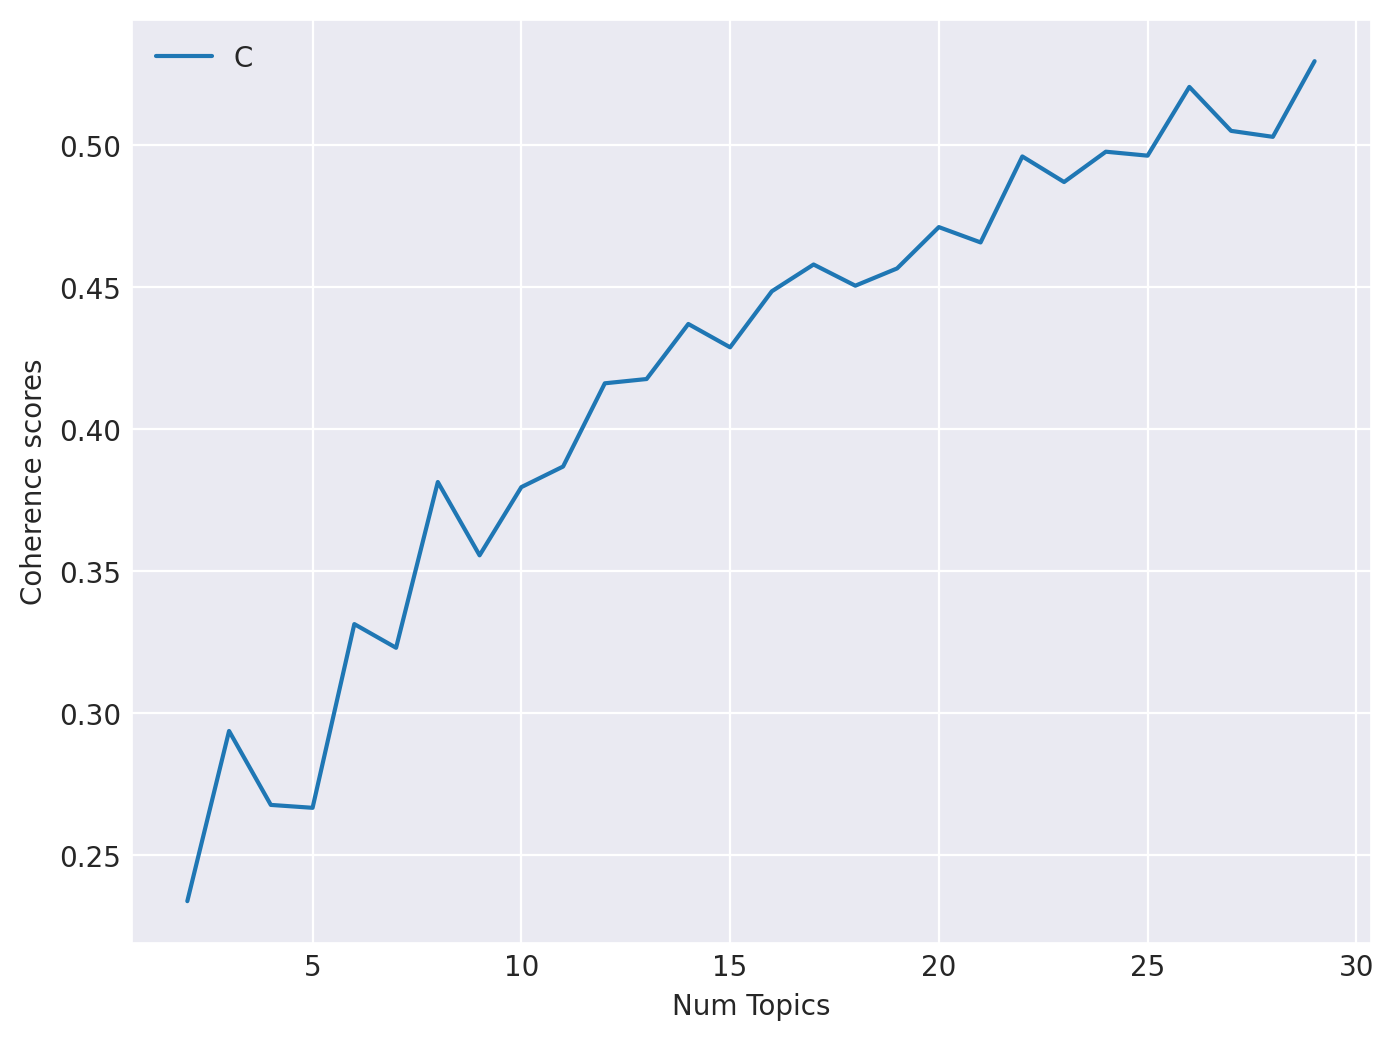

In [ ]:
max_topics=30
models, coherences = testing_models(D,reviews_bow,corpus,max_topics)

x = range(2,max_topics)

# Coherence scores
for n, coherence in zip(x, coherences):
    print("Num Topics =", n, " has Coherence Value of", round(coherence, 4))

# Show graph
plt.plot(x, coherences)
plt.xlabel("Num Topics")
plt.ylabel("Coherence scores")
plt.legend(("Coherence value"), loc='best')
plt.show()

A problem with this method is that the coherence keeps increasing with the number of topics. That is why the pyLDAvis plot is very usefull to see if we dont have too much topics (overlaping)

In [ ]:
# Select the best model
index_higher_coherence = coherences.index(max(coherences))
best_model=models[index_higher_coherence]
del models
print('Optimal number of topics:', best_model.num_topics)
model_topics = best_model.show_topics(formatted=False)
print('10 most important words for each topic:')
for topic in best_model.print_topics(num_words=10):
  print(topic)

Optimal number of topics: 29
10 most important words for each topic:
(12, '0.042*"would" + 0.040*"halloween" + 0.033*"perfect" + 0.028*"new" + 0.026*"stop" + 0.024*"music_video" + 0.021*"announces" + 0.021*"eat" + 0.018*"battle" + 0.018*"animal"')
(6, '0.063*"take" + 0.048*"dog" + 0.043*"go" + 0.030*"canadian" + 0.029*"2" + 0.028*"aid" + 0.021*"halloween_costume" + 0.021*"office" + 0.019*"release" + 0.018*"texas"')
(7, '0.059*"like" + 0.030*"happened" + 0.028*"tried" + 0.020*"28" + 0.020*"beautiful" + 0.019*"cannot" + 0.019*"someone" + 0.019*"iphone" + 0.019*"teen" + 0.017*"judge"')
(17, '0.035*"protest" + 0.030*"christmas" + 0.028*"die" + 0.027*"want" + 0.026*"final" + 0.025*"arrested" + 0.023*"start" + 0.023*"might" + 0.020*"raise" + 0.020*"car"')
(10, '0.048*"game" + 0.030*"test" + 0.027*"house" + 0.026*"second" + 0.025*"iran" + 0.024*"ex" + 0.023*"florida" + 0.021*"well_remember" + 0.016*"medium" + 0.015*"absolutely"')
(14, '0.051*"10" + 0.046*"guess" + 0.030*"31" + 0.029*"cut" + 0

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Based on the most relevant words of each topic we can determine that each topic is:

Topic 0: Miscellaneous topics such as quotes, weddings, and personal matters.

Topic 1: Topics related to pets, particularly dogs, and tweets.

Topic 2: American holidays like Halloween and Thanksgiving.

Topic 3: Topics related to Instagram and pictures.

Topic 4: Zodiac signs.

Topic 5: Teenagers, songs, and journalists.

Topic 6: Military topics.

Topic 7: School-related topics and holidays.

Topic 8: Topics related to children, weeks, and weddings.

Topic 9: Political topics such as Iran, Obama, and attacks.

Topic 10: Topics related to movies, parties, and videos.

Topic 11: Miscellaneous topics such as movies, sex, and parties.

Topic 12: Real-life topics, struggles, and books.

Topic 13: Miscellaneous topics such as movies, sets, and cities.

Topic 14: Topics related to winning, presidents, and arrests.

Topic 15: Financial topics such as banks, arrests, and reports
.
Topic 16: Twitter, services, and Iraq-related topics.

Topic 17: Photograpy topic.

Topic 18: Women, celebrities, and relationships.

Topic 19: Topics related to games, lives, and millions.

Topic 20: Knowledge-related topics.

Topic 21: Time-related topics.

Topic 22: Important characters.

Topic 23: Tragedies, fires, and homes.

Now we can plot the Coherence and Perplexity and compare them with the initial one:

In [ ]:
#Perplexity
print('Perplexity initial 10 topic model: ', lda_model.log_perplexity(reviews_bow))
print('|nPerplexity best model: ', best_model.log_perplexity(reviews_bow))

#Coherence Score
print('\nCoherence Score initial 10 topic model: ', coherence_lda)
print('\nCoherence Score best topic model: ', coherences[index_higher_coherence])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Perplexity initial 10 topic model:  -9.298745689181978
|nPerplexity best model:  -13.975020910346121

Coherence Score initial 10 topic model:  0.40768396305542387

Coherence Score best topic model:  0.5294276353422656


In [ ]:
del lda_model

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


We see that in fact the perplexity is lower (better) and the coherence higher.

Lets also check the plot to see if we cover more of the reconstructed space.

In [ ]:
pyLDAvis.gensim.prepare(best_model, reviews_bow, D)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
27     0.252702 -0.063979       1        1  5.423702
4      0.228102 -0.099088       2        1  4.609075
24     0.068827  0.085689       3        1  3.945838
1     -0.160154 -0.141622       4        1  3.828808
23     0.187123 -0.026089       5        1  3.792996
19     0.120606  0.022572       6        1  3.732139
9     -0.072927  0.091571       7        1  3.691990
18    -0.051982  0.187636       8        1  3.514075
28     0.004828  0.038369       9        1  3.490110
21    -0.120831 -0.079441      10        1  3.484414
8     -0.032376 -0.179903      11        1  3.468618
11    -0.067637 -0.036258      12        1  3.460933
3     -0.096611  0.053071      13        1  3.426449
15    -0.033244 -0.050898      14        1  3.398715
26    -0.128188  0.019992      15        1  3.366312
13    -0.056693  0.009495      16        1  3.326728
0     -0.087174  0.103989      17        1  3.283945
5     -0.006912 -0.089651      18        1  3.263861
20    -0.053308 -0.064565      19        1  3.199523
25    -0.064726  0.081017      20        1  3.165818
2      0.086016  0.030737      21        1  3.160735
16     0.068078  0.059642      22        1  3.147187
10    -0.083701 -0.095602      23        1  3.094893
6     -0.039166 -0.134883      24        1  3.081738
17    -0.036199 -0.000976      25        1  3.056232
22     0.079890 -0.013936      26        1  3.007489
14     0.076046  0.077421      27        1  2.949408
7      0.020225  0.136232      28        1  2.875671
12    -0.000613  0.079458      29        1  2.752598, topic_info=           Term         Freq        Total Category  logprob  loglift
297       thing  1047.000000  1047.000000  Default  30.0000  30.0000
319        know   753.000000   753.000000  Default  29.0000  29.0000
605        time   784.000000   784.000000  Default  28.0000  28.0000
30       people   995.000000   995.000000  Default  27.0000  27.0000
83           wa   539.000000   539.000000  Default  26.0000  26.0000
...         ...          ...          ...      ...      ...      ...
247   announces    86.805672   114.043538  Topic29  -3.8495   3.3197
776    hospital    38.709403    42.289797  Topic29  -4.6571   3.5042
251         new   115.121576   955.107875  Topic29  -3.5672   1.4768
1380     making    39.118044    67.980711  Topic29  -4.6466   3.0400
55     actually    35.685514   614.999369  Topic29  -4.7385   0.7457

[1310 rows x 6 columns], token_table=      Topic      Freq         Term
term                              
552       7  0.951261          00s
219       6  0.955512            1
219      23  0.034620            1
641       6  0.008879           10
641      27  0.981077           10
...     ...       ...          ...
3803     25  0.955997         york
1033     19  0.953221        young
1205     18  0.023336  zodiac_sign
1205     21  0.011668  zodiac_sign
1205     24  0.956767  zodiac_sign

[2834 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[28, 5, 25, 2, 24, 20, 10, 19, 29, 22, 9, 12, 4, 16, 27, 14, 1, 6, 21, 26, 3, 17, 11, 7, 18, 23, 15, 8, 13])

Indeed we see that the bubles are less overlaping and cover more of the feature space

### Vector representation with LDA

We can use the LDA to obtain a vector representation of each document in base of the topics it is represented by.


In [ ]:
#Dictionary to store the vector representations and topics of each document
document_topics_dict = {}
lda_gensim_embedding_matrix = np.zeros((len(all_lemmas_phrases), best_model.num_topics))
for i, bow_documento in enumerate(reviews_bow):
    nombre_documento = all_lemmas_phrases[i]

    # This is the topic distribution of each document
    distribucion_temas, _, _ = best_model.get_document_topics(bow=bow_documento, per_word_topics=True)

    vector_temas = [0] * best_model.num_topics
    for tema, probabilidad in distribucion_temas:
        vector_temas[tema] = probabilidad
        lda_gensim_embedding_matrix[i][tema]=probabilidad
    document_topics_dict[nombre_documento] = (vector_temas, distribucion_temas)

lda_gensim_embedding_matrix.shape

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(26000, 29)

In [ ]:
#Print the results for the first 10 documents
contador = 0
for nombre_documento, (vector_temas, distribucion_temas) in document_topics_dict.items():
    print("Document:", nombre_documento)
    print("Vectorial representation:", vector_temas)
    print("Representative topics:", distribucion_temas)
    print()
    contador += 1
    if contador >= 10:
        break


Document: honey_boo boo walking beverly_hill honey_boo boo thing_ever
Vectorial representation: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.58634514, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.20044442]
Representative topics: [(12, 0.58634514), (28, 0.20044442)]

Document: could speak mental disorder
Vectorial representation: [0.19646023, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.59075505, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Representative topics: [(0, 0.19646023), (11, 0.59075505)]

Document: memphis us size speed overpower marylandgrammar school flood queensland sunshine_coast
Vectorial representation: [0, 0, 0, 0, 0, 0, 0, 0, 0.113180414, 0, 0, 0, 0.3308097, 0, 0, 0.11324192, 0.11317099, 0.11314912, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.1142328, 0]
Representative topics: [(8, 0.113180414), (12, 0.3308097), (15, 0.11324192), (16, 0.11317099), (17, 0.11314912), (27, 0.1142328)]

Document: futuristic
Vectorial representation: [0.033935998, 0.03466254, 0.03402557, 0.03398908, 0.037392244, 0.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Finding the dominant topic in each sentence

A practical application of topic modeling involves identifying the subject matter of a given document. This is achieved by identifying the topic number with the highest percentage contribution within the document.

In [ ]:
def best_topics_for_title(ldamodel, corpus, texts):
    best_topics = []

    # Best topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic for each document
        best_topic = row[0][0]  # Get the topic with the highest probability
        best_topics.append((str('document '+str(i)), str('topic '+str(best_topic+1))))

    return best_topics

# Call the function to get the best topics for each document
best_topics = best_topics_for_title(ldamodel=best_model, corpus=reviews_bow, texts=all_lemmas_phrases)
best_topics[:10]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


[('document 0', 'topic 13'),
 ('document 1', 'topic 12'),
 ('document 2', 'topic 13'),
 ('document 3', 'topic 28'),
 ('document 4', 'topic 18'),
 ('document 5', 'topic 21'),
 ('document 6', 'topic 19'),
 ('document 7', 'topic 18'),
 ('document 8', 'topic 15'),
 ('document 9', 'topic 11')]

#### Final plot to see the **distribution of documents per topic**:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


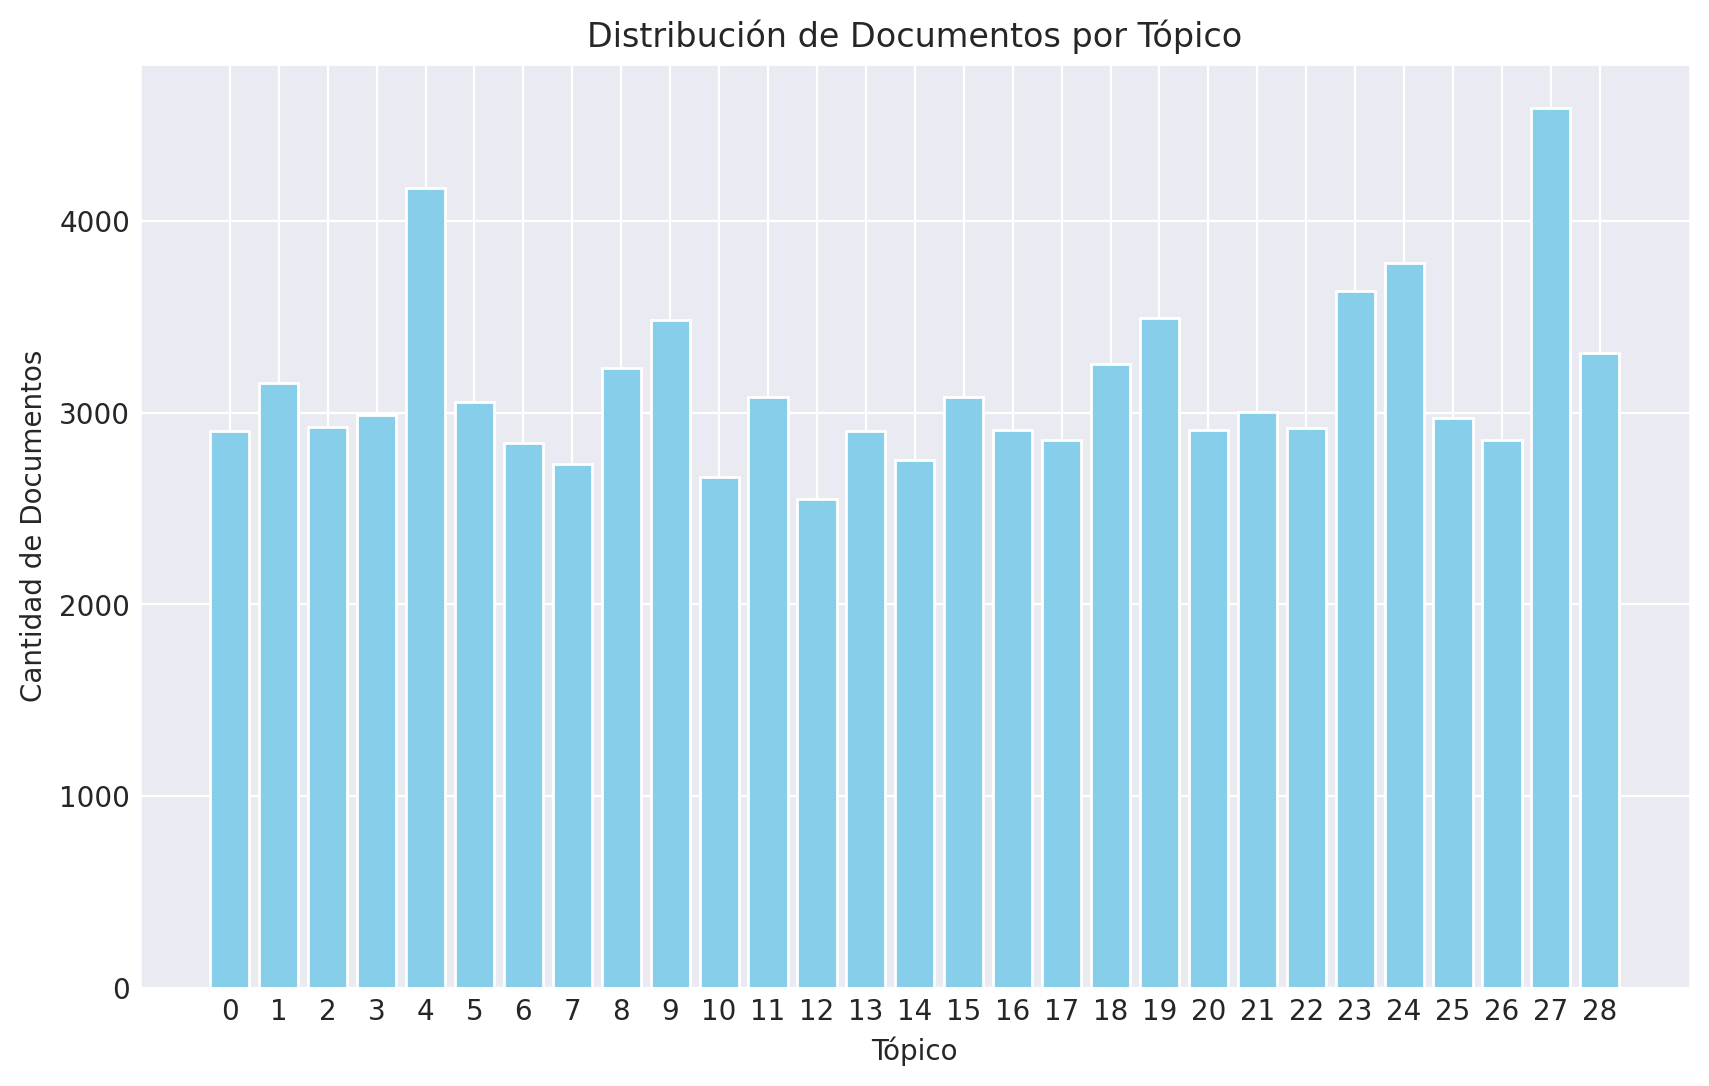

In [ ]:
import matplotlib.pyplot as plt

# Obtener la cantidad de documentos asignados a cada tópico
documentos_por_topico = [0] * best_model.num_topics
for _, distribucion_temas in document_topics_dict.values():
    for tema, probabilidad in distribucion_temas:
        if probabilidad > 0.09:  # Considerar solo las asignaciones de tópicos con probabilidad mayor que 0.09
            documentos_por_topico[tema] += 1

# Crear el gráfico de barras
plt.figure(figsize=(10, 6))
plt.bar(range(best_model.num_topics), documentos_por_topico, color='skyblue')
plt.xlabel('Tópico')
plt.ylabel('Cantidad de Documentos')
plt.title('Distribución de Documentos por Tópico')
plt.xticks(range(best_model.num_topics))
plt.show()


### Topic Modeling with Sklearn

We are going to use LDA to extract the main topics of our news. After extracting them, we are going to see the 10 words that define each of the 20 topics and give an interpretation of what that topic could be. In this way we will compare which topic modeling is better, with Gensim or with Sklearn

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(all_lemmas_phrases)

#Apply LDA to find the latent topics in the documents
lda = LatentDirichletAllocation(n_components=best_model.num_topics, random_state=42)
lda.fit(X)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


LatentDirichletAllocation(n_components=29, random_state=42)

#### Finding the vector representation and the dominant topic for each sentence is easier in sklearn



In [ ]:
#Print the contribution of each topic to each document
topic_assignments = lda.transform(X)
count=0
for i, distribucion_topico in enumerate(topic_assignments):
    print(f"Documento {i} --> Vectorial representation: {distribucion_topico}")
    count+=1
    if count>10:
      break

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Documento 0 --> Vectorial representation: [0.00431034 0.00431034 0.00431034 0.00431034 0.00431034 0.00431034
 0.00431034 0.00431034 0.00431034 0.00431034 0.00431034 0.75431034
 0.00431034 0.12931034 0.00431034 0.00431034 0.00431034 0.00431034
 0.00431034 0.00431034 0.00431034 0.00431034 0.00431034 0.00431034
 0.00431034 0.00431034 0.00431034 0.00431034 0.00431034]
Documento 1 --> Vectorial representation: [0.00862069 0.00862069 0.00862069 0.00862069 0.00862069 0.00862069
 0.00862069 0.00862069 0.00862069 0.00862069 0.00862069 0.00862069
 0.00862069 0.00862069 0.00862069 0.00862069 0.00862069 0.00862069
 0.25862069 0.00862069 0.00862069 0.00862069 0.00862069 0.00862069
 0.00862069 0.00862069 0.00862069 0.50862069 0.00862069]
Documento 2 --> Vectorial representation: [0.00344828 0.00344828 0.00344828 0.00344828 0.00344828 0.00344828
 0.00344828 0.00344828 0.00344828 0.00344828 0.00344828 0.00344828
 0.00344828 0.00344828 0.00344828 0.00344828 0.00344828 0.00344828
 0.00344828 0.00344828 

In [ ]:
#Assign each document to the predominant topic
dominant_topics = topic_assignments.argmax(axis=1)

count=0
for i, doc_topic in enumerate(dominant_topics):
    print(f"Texto {i + 1}: Tópico {doc_topic + 1}")
    count+=1
    if count>10:
      break

Texto 1: Tópico 12
Texto 2: Tópico 28
Texto 3: Tópico 28
Texto 4: Tópico 23
Texto 5: Tópico 6
Texto 6: Tópico 22
Texto 7: Tópico 22
Texto 8: Tópico 18
Texto 9: Tópico 14
Texto 10: Tópico 6
Texto 11: Tópico 23


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
#Get the most representative words for each topic
feature_names = vectorizer.get_feature_names_out()
topic_word_distribution = lda.components_

#Display the most representative words for each topic
num_top_words = 10  #Number of top words to display per topic.
for topic_idx, topic_words in enumerate(topic_word_distribution):
    print(f"Tópico {topic_idx + 1}:")
    top_words_idx = topic_words.argsort()[::-1][:num_top_words]
    top_words = [feature_names[i] for i in top_words_idx]
    print(top_words)


Tópico 1:
['guess', 'happens', 'old', 'color', 'lady_gaga', 'dress', 'type', 'gorgeous', 'man', '30']
Tópico 2:
['win', 'uk', 'government', 'iraq', 'new', 'leader', 'obama', 'minister', 'say', 'nuclear']
Tópico 3:
['well_remember', 'earthquake', 'tiny', 'history', 'hogwarts_house', 'adult', 'say', 'water', 'york', 'death_toll']
Tópico 4:
['taylor_swift', 'men', 'day', 'like', 'ha', 'woman', 'year_old', 'thing_happen', 'bff', '2015']
Tópico 5:
['star_war', 'time', 'hilarious', 'wa', 'ha', 'make', 'watch', 'new', 'reason', '100']
Tópico 6:
['single', 'woman', 'life', 'new', 'wa', 'mean', 'light', 'say', 'song', 'released']
Tópico 7:
['halloween', '2008', 'day', 'world', 'biggest', 'india', 'family', 'model', 'new', 'year']
Tópico 8:
['27', 'america', 'new', 'people_try', 'anxiety', 'help', 'week', 'record', 'make', 'year']
Tópico 9:
['tweet', 'make_laugh', '24', 'kid', 'every_time', 'make', 'relate', '19', 'honest', 'school']
Tópico 10:
['16', 'service', 'fall', 'bad', 'advice', 'puppy',

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Based on the words, we think that a reasonable interpretation of each topic is:

Topic 1: Culture

Topic 2: GeoPolitics

Topic 3: Entertainment

Topic 4: Reflection

Topic 5: Novelty

Topic 6: Music

Topic 7: Film

Topic 8: Security

Topic 9: Humor

Topic 10: Globalization

Topic 11: Current affairs

Topic 12: Creativity

Topic 13: Fun

Topic 14: Variety

Topic 15: Celebration

Topic 16: Photography

Topic 17: Emotion

Topic 18: Experience

Topic 19: Personality

Topic 20: Conversation

Topic 21: Intrigue

Topic 22: Challenge

Topic 23: Pleasure

Topic 24: Drama

Final measures to compare the models

In [ ]:
CoherenceModel(topics=top_words, texts=corpus, dictionary=D, coherence='c_v').get_coherence()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


0.6126220249178707

We see that the sklearn LDA model is significantly better than the other one, and indeed the topics make more sense

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


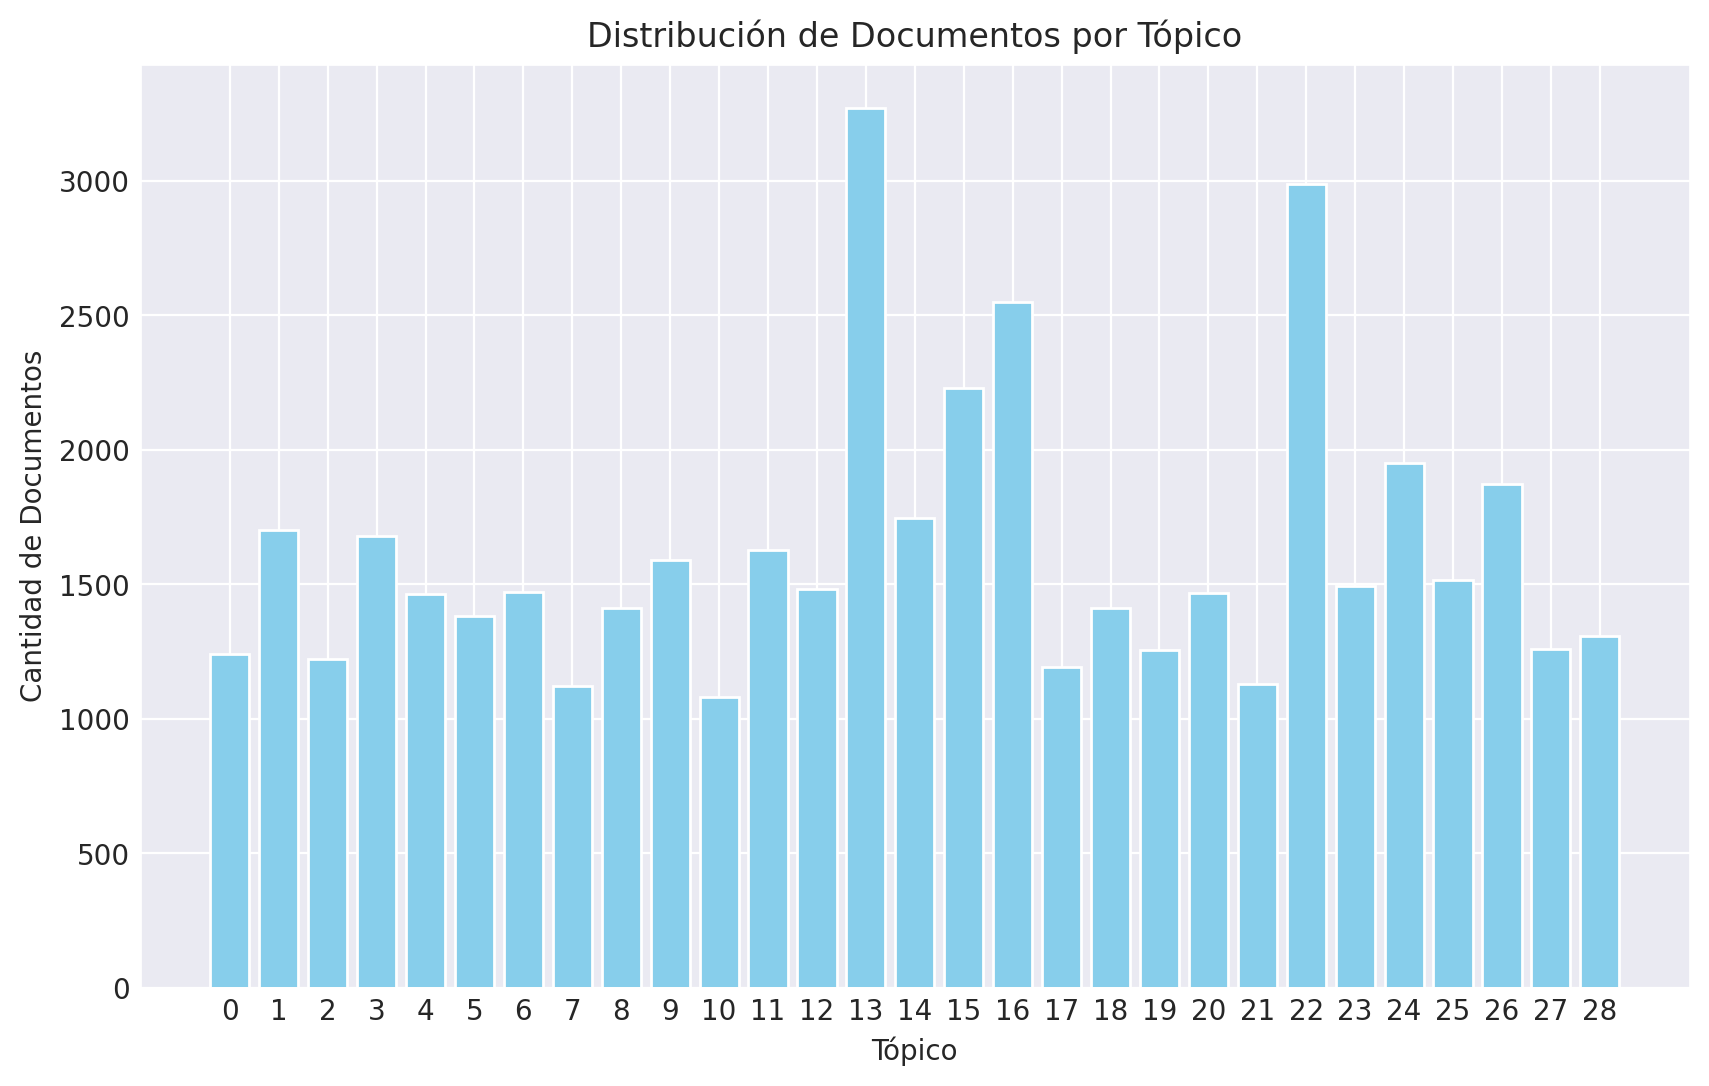

In [ ]:
import matplotlib.pyplot as plt

#Count the number of documents assigned to each topic
documentos_por_topico = [0] * lda.n_components
for distribucion_topico in topic_assignments:
    for i, probabilidad in enumerate(distribucion_topico):
        if probabilidad > 0.1:  # "Consider only topic assignments with higher probability que 0.1 due to sklearn particularities (see report)
            documentos_por_topico[i] += 1

plt.figure(figsize=(10, 6))
plt.bar(range(lda.n_components), documentos_por_topico, color='skyblue')
plt.xlabel('Tópico')
plt.ylabel('Cantidad de Documentos')
plt.title('Distribución de Documentos por Tópico')
plt.xticks(range(lda.n_components))
plt.show()


### Clickbait classification with LDA vector representation

Of course we can use this vectors of topics weights, that represents the titles, to create an embedding matrix and perform an SVM classification.
We do not expect the results to be as accurate as using other direct vctorization methods such as word2vec representation, but it could work correctly anyway. As the Coherence Score is higher with the sklearn implementation and we think the intuition of the topics makes more sense we are going to use it as vector representation.

In [ ]:
embedding_matrices = []

for distribucion_topico in topic_assignments:
    embedding_matrices.append(np.expand_dims(distribucion_topico, axis=0))

lda_embedding_matrix = np.concatenate(embedding_matrices, axis=0)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Splitting the data into training and test sets
X_train_lda, X_test_lda, y_train_lda, y_test_lda = train_test_split(lda_embedding_matrix, Y, test_size=0.3, random_state=42)

param_grid = {'C':  [12.8,13.2,13.5],
              'kernel': ['linear', 'rbf']}
# Perform grid search for SVM classifier with GloVe embeddings
grid_search_lda = GridSearchCV(svm, param_grid, cv=5)
grid_search_lda.fit(X_train_lda, y_train_lda)

# Get the best parameters for SVM classifier with GloVe embeddings
best_params_lda = grid_search_lda.best_params_

# Initialize SVM classifier with best parameters
svm_best_lda = SVC(C=best_params_lda['C'], kernel=best_params_lda['kernel'])
svm_best_lda.fit(X_train_lda, y_train_lda)

# Evaluate the performance of the classifier with GloVe embeddings
y_pred_lda = svm_best_lda.predict(X_test_lda)
accuracy_lda = accuracy_score(y_test_lda, y_pred_lda)

print("Best parameters with Doc2Vec embeddings:", best_params_lda)
print("Accuracy on test set with Doc2Vec embeddings:", accuracy_lda)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best parameters with Doc2Vec embeddings: {'C': 13.5, 'kernel': 'rbf'}
Accuracy on test set with Doc2Vec embeddings: 0.7944871794871795


As we expected the accuracy is barely 80%. That is firstly, because LDA is centered on learning the latent topics under the documents, whichs ends up providing a vector representation of those, but not on directly transforming the documents into vector representations that maximize the information gain and representance. Also, here we are using 24 topics to define each documents, that is an embedding size of 24, which is a much smaller embedding dimensional size than other vectorization methods.

Now we are going to save all the embedding matrices (vector representation of documents) and the corpus dataframe to use them on the dash gallery

In [ ]:
import numpy as np
from scipy.sparse import load_npz

# Full path of the files
ruta_directorio = '/content/drive/My Drive/FInal Proyect ML/Processed data/'

# Save the DataFrame as a CSV file
corpus_df.to_csv(ruta_directorio + 'corpus_df.csv', index=False)

# Save lda_embedding_matrix to a .npy file
np.save(ruta_directorio + 'lda_embedding_matrix.npy', lda_embedding_matrix)
np.save(ruta_directorio + 'lda_gensim_embedding_matrix.npy', lda_gensim_embedding_matrix)

# Save d2v_embedding_matrix to a .npy file
np.save(ruta_directorio + 'd2v_embedding_matrix.npy', d2v_embedding_matrix)

np.save(ruta_directorio + 'w2v_embedding_matrix.npy', w2v_embedding_matrix)
np.save(ruta_directorio + 'glove_embedding_matrix.npy', glove_embedding_matrix)

# Save corpus_bow_sparse to a .npz file
np.save(ruta_directorio + 'corpus_bow_dense.npy', corpus_bow_dense)

# Save corpus_tfidf_sparse to a .npz file
np.save(ruta_directorio + 'corpus_tfidf_dense.npy', corpus_tfidf_dense)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## News Clustering

Lets see if we are able of permorming a good division of documents in meaningful groups using the previously computed embedding. Additionaly, this will help us see graphicallly which is the best vector representation of the documents, in the sense os distinguishing between clickbait and non-clickbait documents.

First, lets reduce the dimensionality of the different embedding matrices with PCA

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.decomposition import PCA

# Reduce dimensionality with PCA
pca = PCA(n_components=2)
glove_embedding_matrix_2d = pca.fit_transform(glove_embedding_matrix)
w2v_embedding_matrix_2d = pca.fit_transform(w2v_embedding_matrix)
d2v_embedding_matrix_2d = pca.fit_transform(d2v_embedding_matrix)

# Apply KMeans for clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters_glove = kmeans.fit_predict(glove_embedding_matrix_2d)
w2v_clusters = kmeans.fit_predict(w2v_embedding_matrix_2d)
d2v_clusters = kmeans.fit_predict(d2v_embedding_matrix_2d)

# Evaluate the clustering performance
ari_glove = adjusted_rand_score(corpus_df["is_clickbait"], clusters_glove)
nmi_glove = normalized_mutual_info_score(corpus_df["is_clickbait"], clusters_glove)

ari_w2v = adjusted_rand_score(corpus_df["is_clickbait"], w2v_clusters)
nmi_w2v = normalized_mutual_info_score(corpus_df["is_clickbait"], w2v_clusters)

ari_d2v = adjusted_rand_score(corpus_df["is_clickbait"], d2v_clusters)
nmi_d2v = normalized_mutual_info_score(corpus_df["is_clickbait"], d2v_clusters)

# Print evaluation metrics
print("Adjusted Rand Index Glove: {:.3f}".format(ari_glove))
print("Normalized Mutual Information Glove: {:.3f}".format(nmi_glove))
print("Adjusted Rand Index Word2Vec: {:.3f}".format(ari_w2v))
print("Normalized Mutual Information Word2Vec: {:.3f}".format(nmi_w2v))
print("Adjusted Rand Index Doc2Vec: {:.3f}".format(ari_d2v))
print("Normalized Mutual Information Doc2Vec: {:.3f}".format(nmi_d2v))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

Adjusted Rand Index Glove: 0.608
Normalized Mutual Information Glove: 0.690
Adjusted Rand Index Word2Vec: 0.486
Normalized Mutual Information Word2Vec: 0.516
Adjusted Rand Index Doc2Vec: 0.394
Normalized Mutual Information Doc2Vec: 0.456


Also lets see the Silhouette Score

In [ ]:
from sklearn.metrics import silhouette_score

# Calculate silhouette score for GloVe embeddings
silhouette_glove = silhouette_score(glove_embedding_matrix_2d, clusters_glove)
print("Silhouette Score for GloVe embeddings:", silhouette_glove)

# Calculate silhouette score for Word2Vec embeddings
silhouette_w2v = silhouette_score(w2v_embedding_matrix_2d, w2v_clusters)
print("Silhouette Score for Word2Vec embeddings:", silhouette_w2v)

# Calculate silhouette score for Doc2Vec embeddings
silhouette_d2v = silhouette_score(d2v_embedding_matrix_2d, d2v_clusters)
print("Silhouette Score for Doc2Vec embeddings:", silhouette_d2v)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Silhouette Score for GloVe embeddings: 0.8131067282475524
Silhouette Score for Word2Vec embeddings: 0.8368840535465961
Silhouette Score for Doc2Vec embeddings: 0.37261456123328746


For a deeper analisys lets see how each embedding affects the differentiation of clickbait news in the reduced dimensional space

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


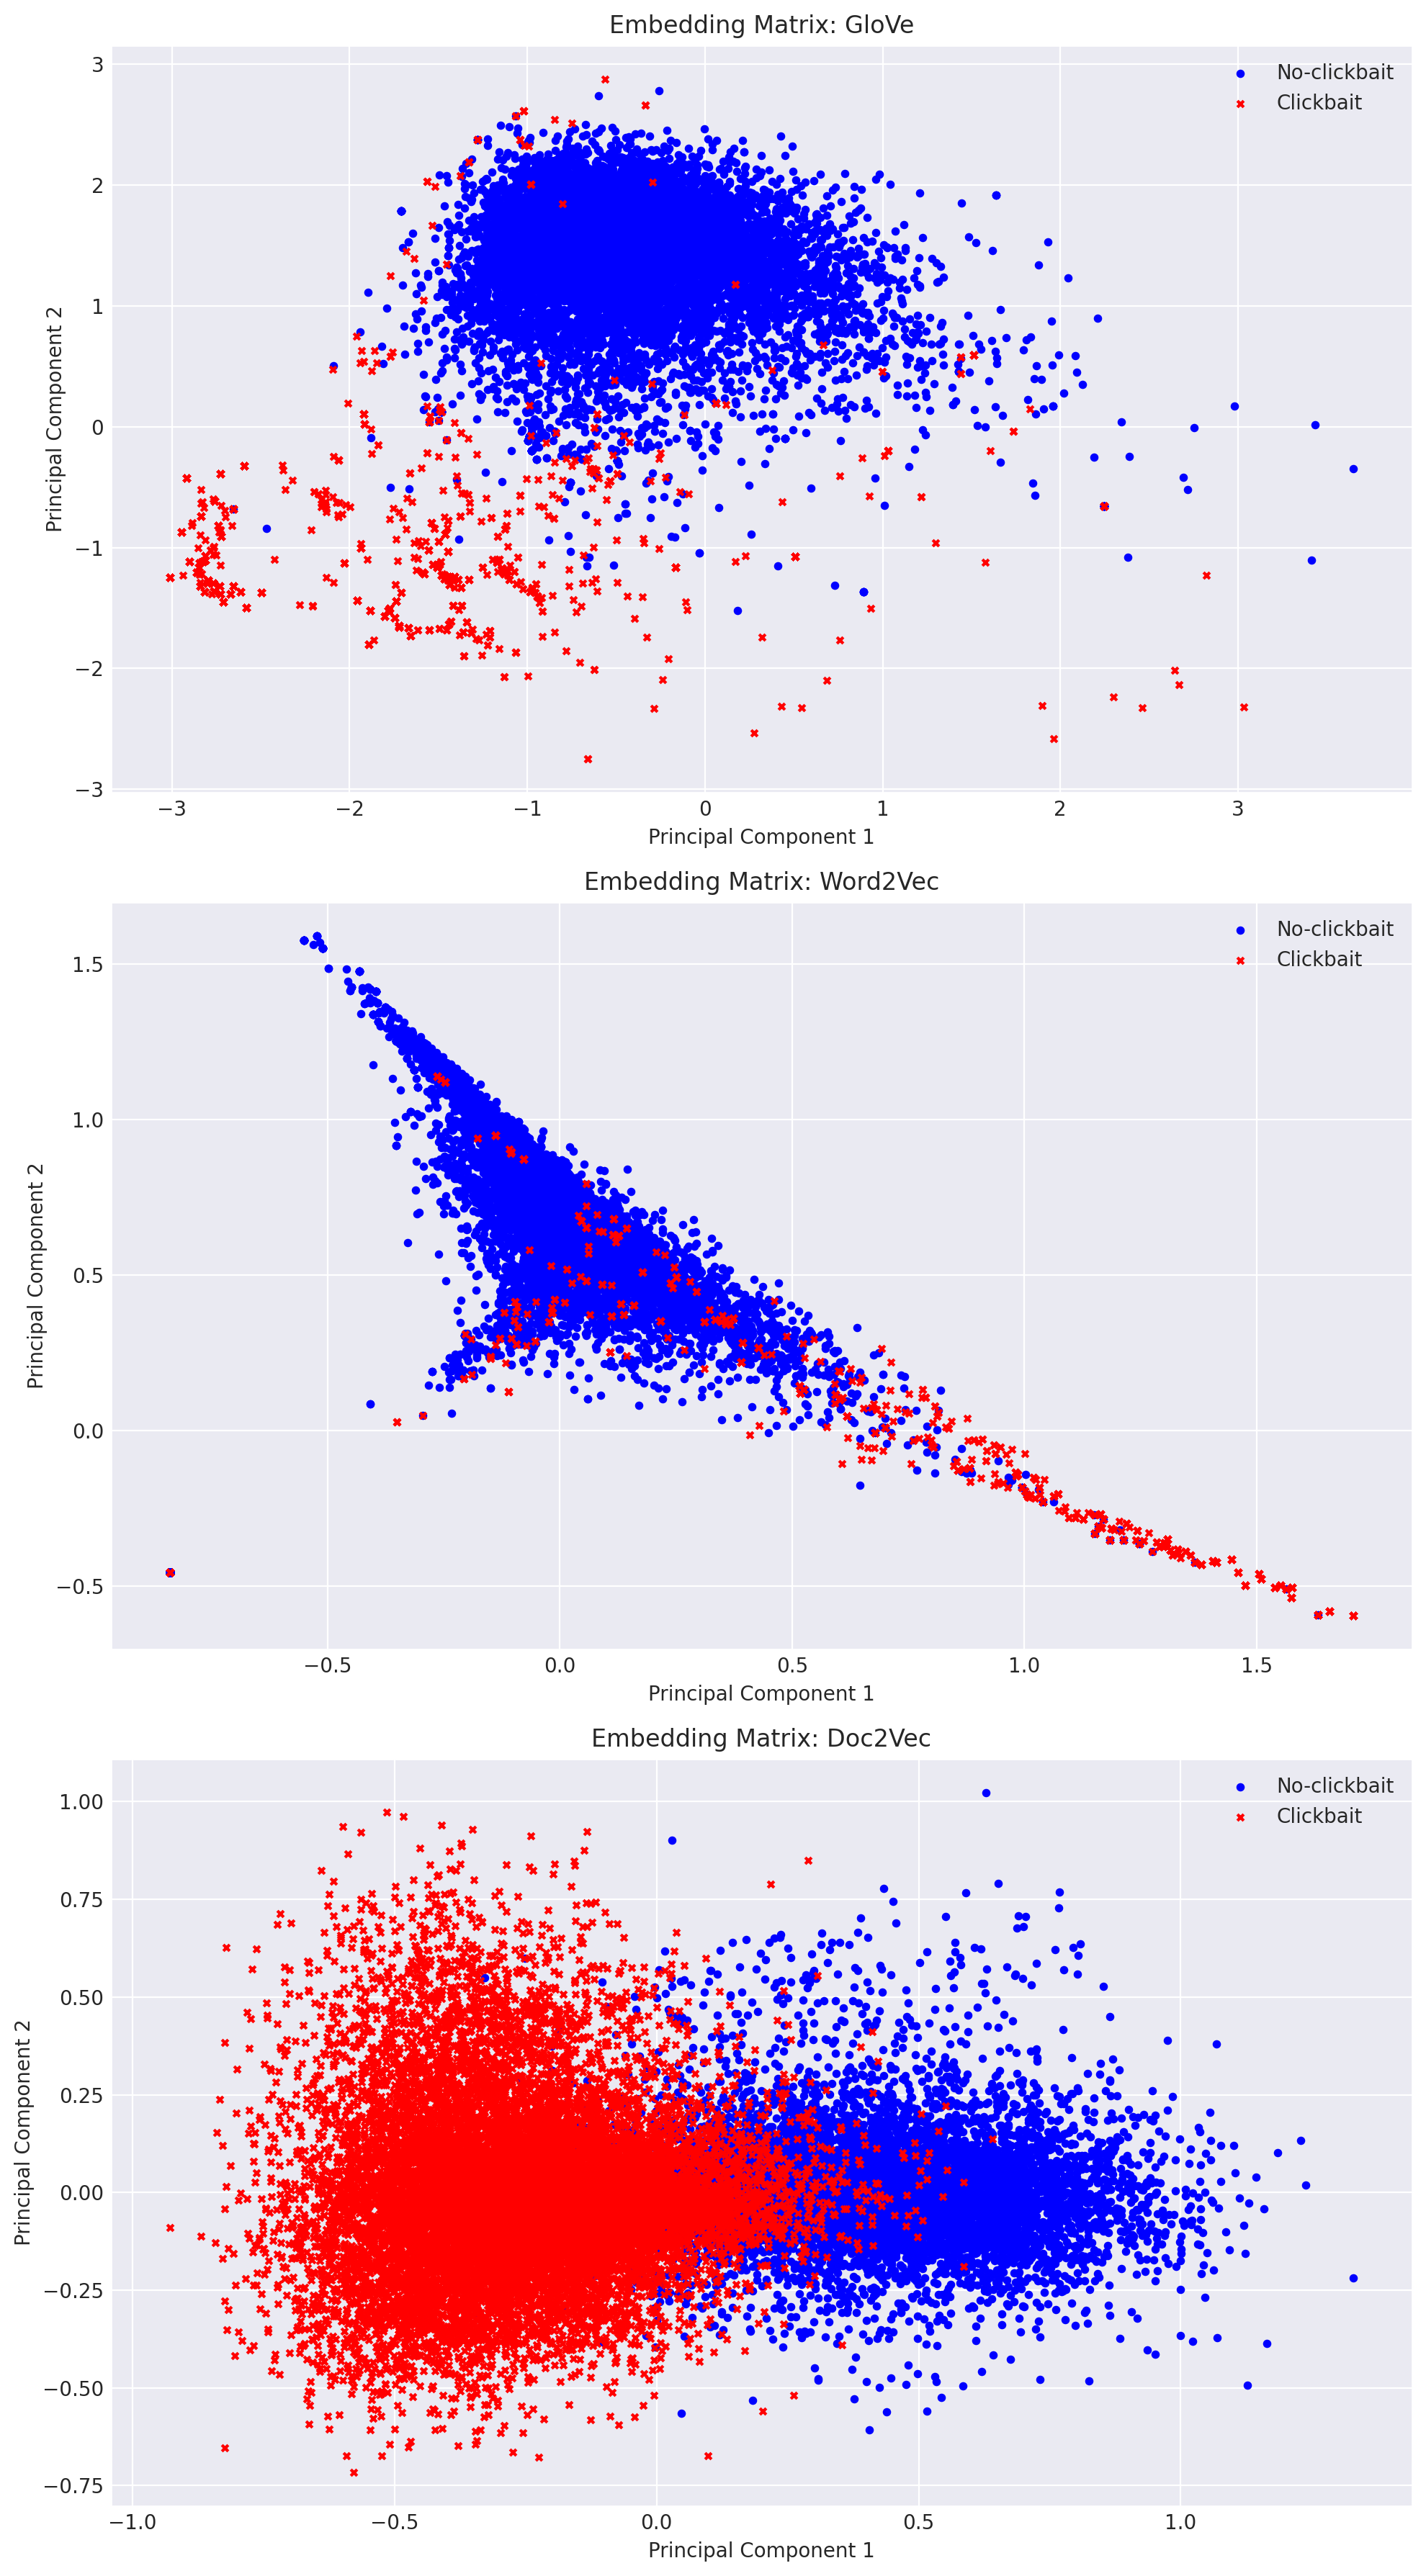

In [ ]:
import matplotlib.pyplot as plt

# Define the embedding matrices and their strategy names
embedding_matrices = [
    (glove_embedding_matrix_2d, 'GloVe'),
    (w2v_embedding_matrix_2d, 'Word2Vec'),
    (d2v_embedding_matrix_2d, 'Doc2Vec')
]

num_rows = len(embedding_matrices)
num_cols = 1

# Create the subplot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 6*num_rows))

# Iterate over each embedding matrix and create a scatterplot for each one
for i, (embedding_matrix, strategy_name) in enumerate(embedding_matrices):
    # Differentiate between clickbait and non-clickbait

    clickbait_indices = corpus_df[corpus_df['is_clickbait'] == 1].index
    non_clickbait_indices = corpus_df[corpus_df['is_clickbait'] == 0].index

    # Plot clickbait and non-clickbait news
    axes[i].scatter(embedding_matrix[non_clickbait_indices, 0], embedding_matrix[non_clickbait_indices, 1], c='b', marker='o', label='No-clickbait', s=10)
    axes[i].scatter(embedding_matrix[clickbait_indices, 0], embedding_matrix[clickbait_indices, 1], c='r', marker='x', label='Clickbait', s=10)

    axes[i].set_title(f'Embedding Matrix: {strategy_name}')
    axes[i].set_xlabel('Principal Component 1')
    axes[i].set_ylabel('Principal Component 2')
    axes[i].legend()

plt.tight_layout()
plt.show()


Also lets see how many clickbait and non-clickbait news fall on each cluster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


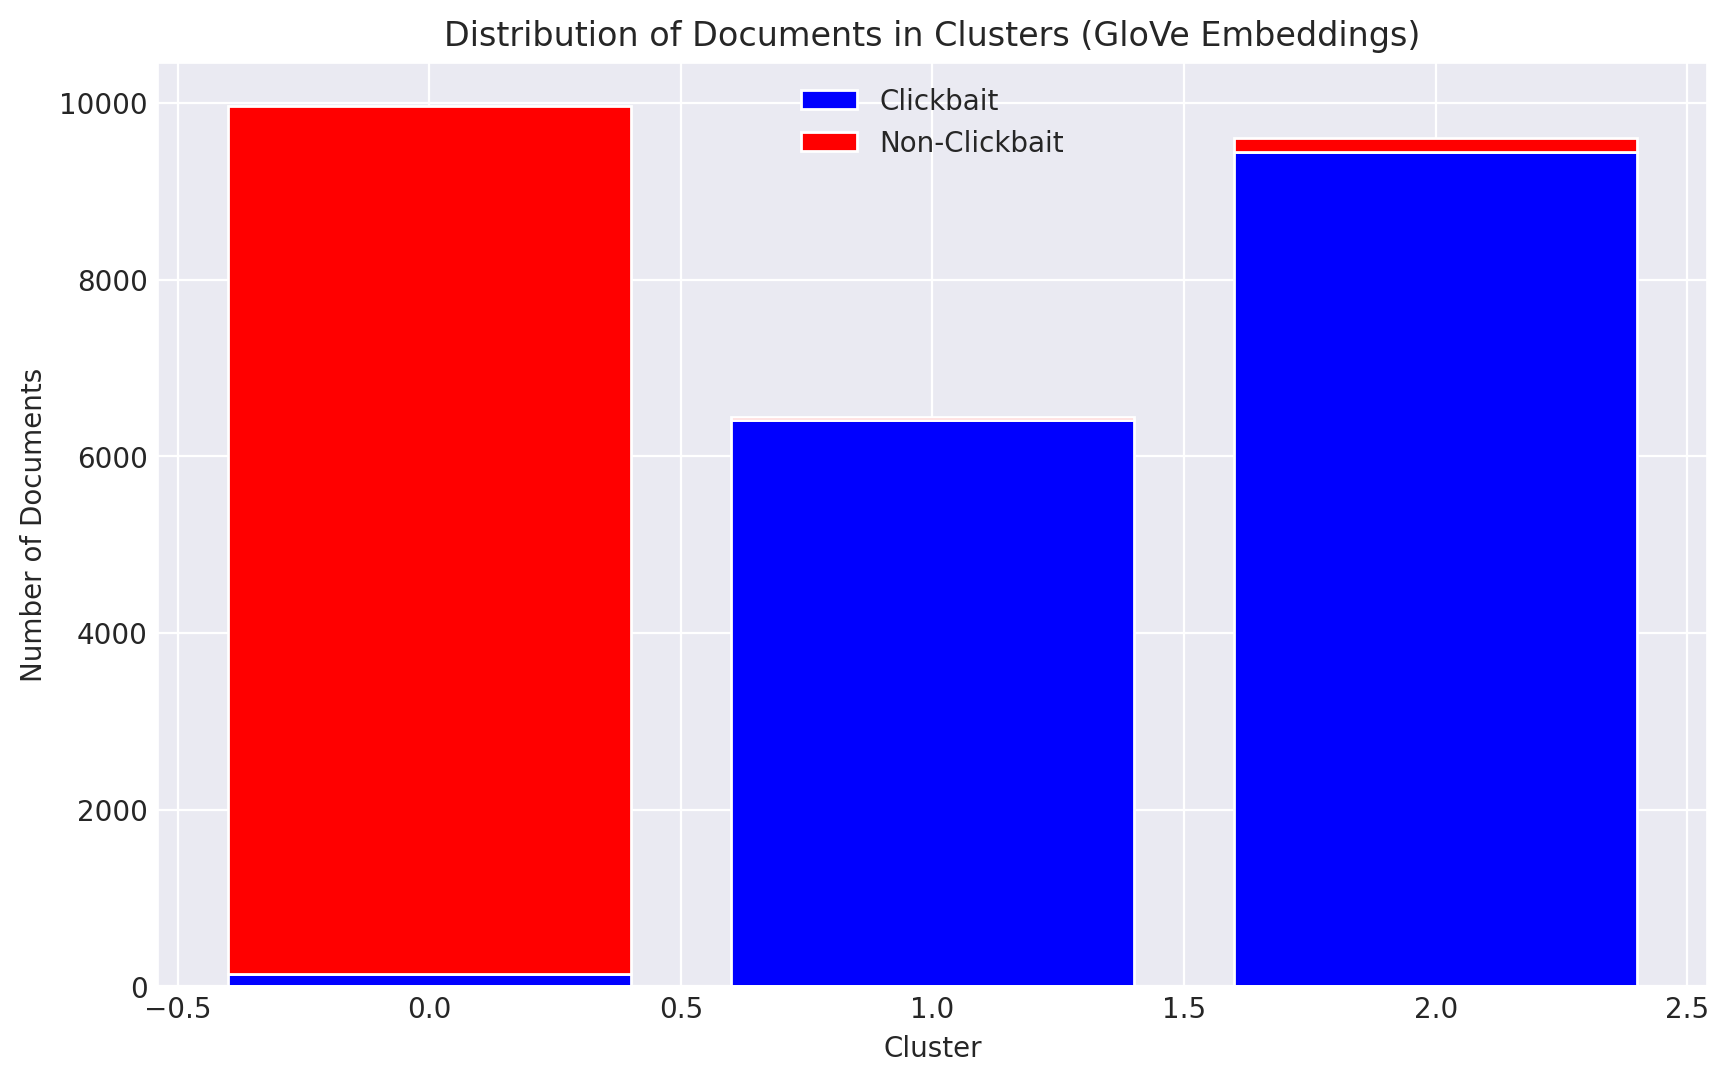

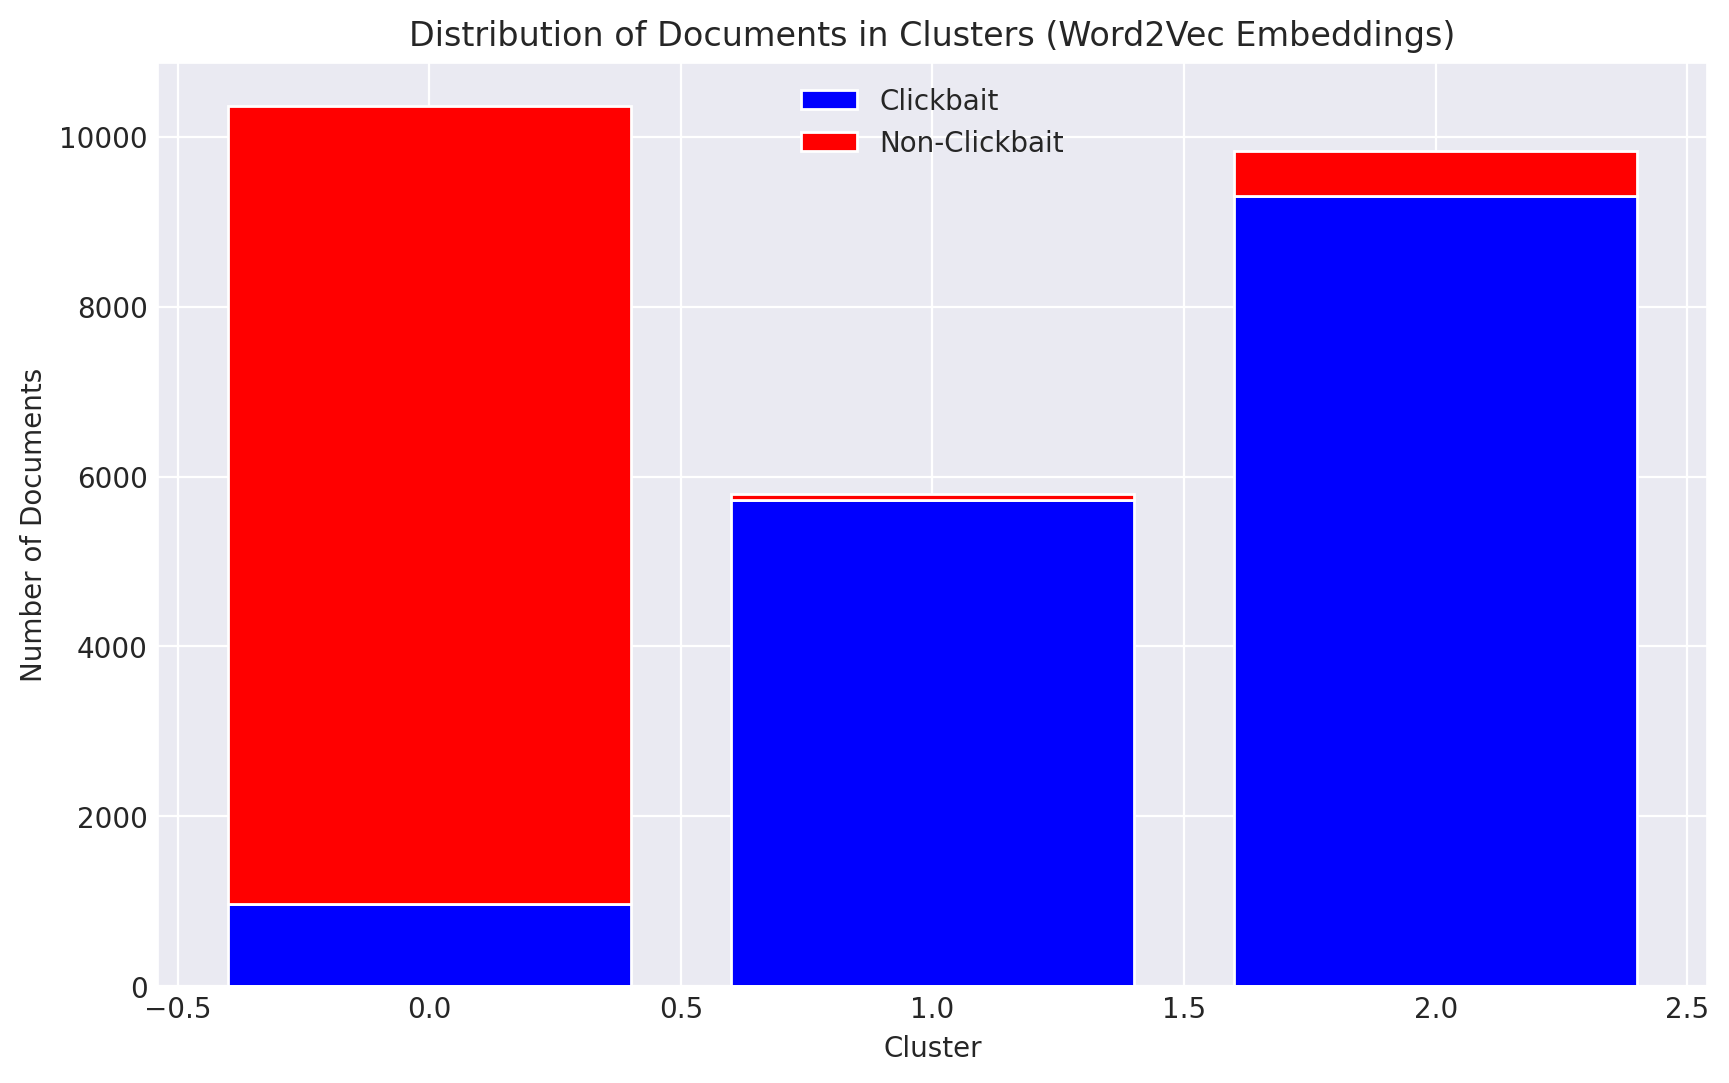

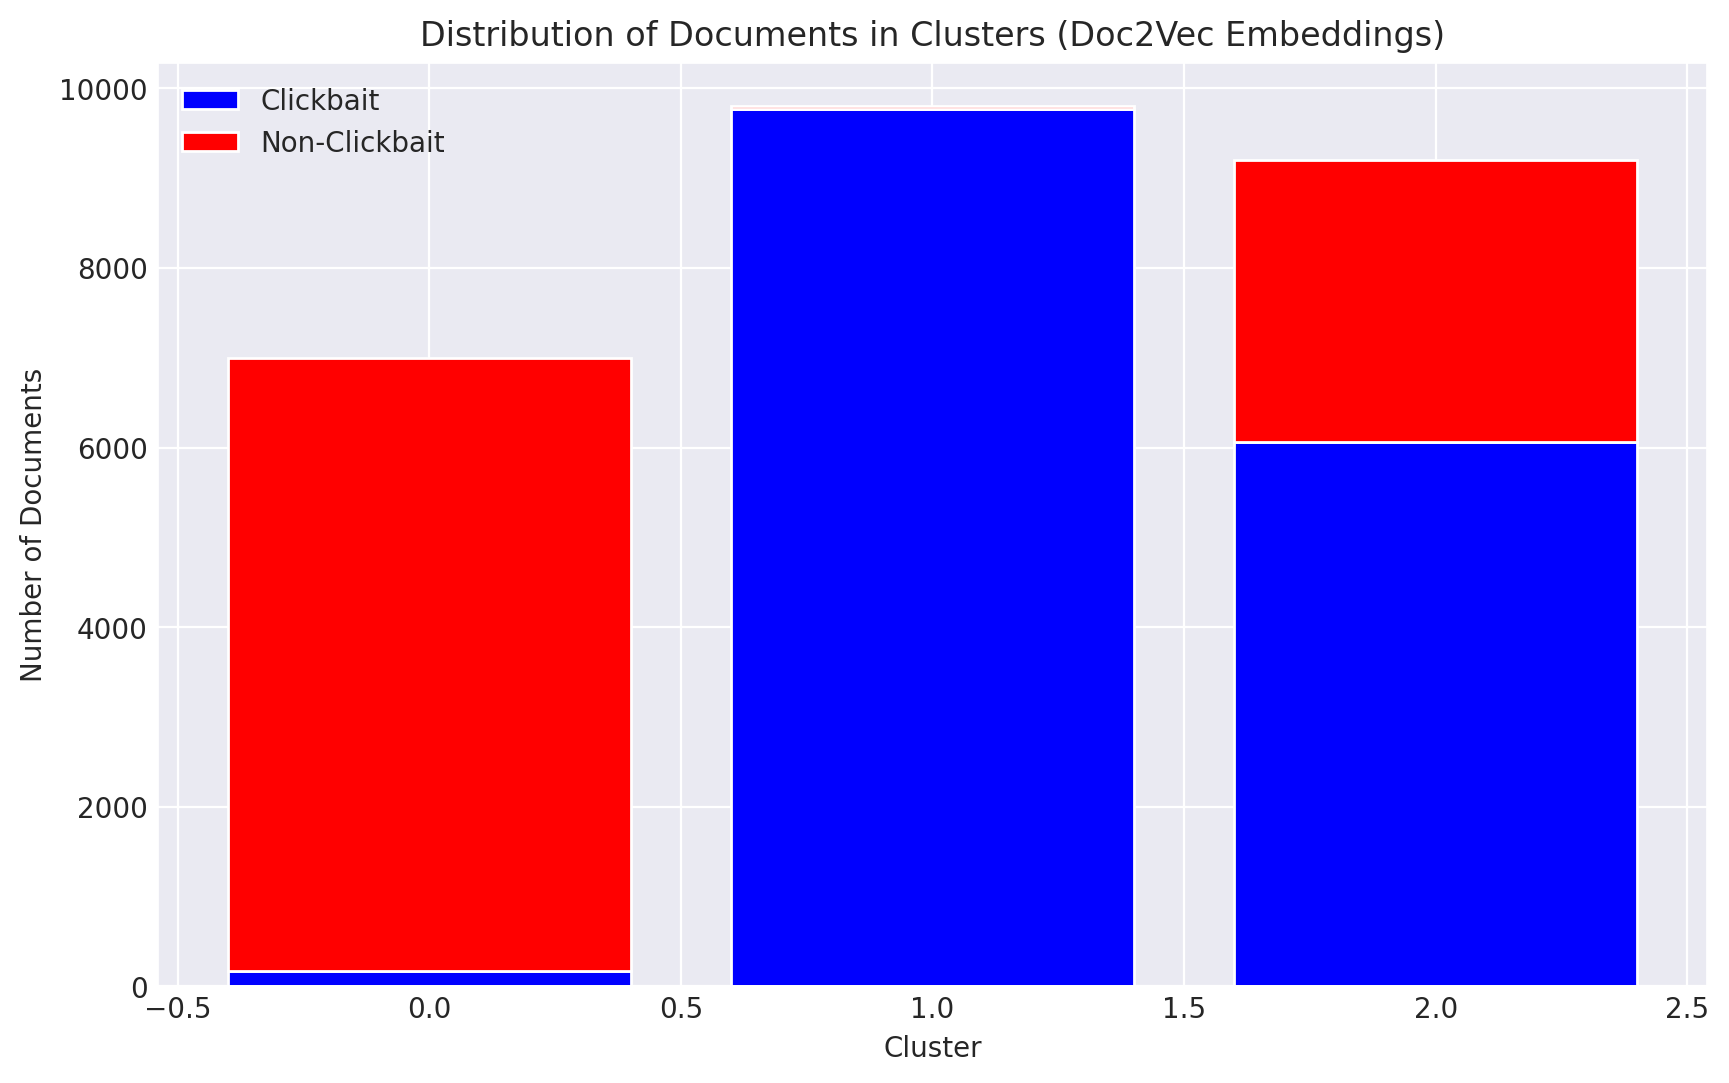

In [ ]:
# Function to count the number of documents in each cluster
def count_documents_per_cluster(clusters, clickbait_labels):
    unique_clusters, counts = np.unique(clusters, return_counts=True)
    clickbait_counts = [np.sum(clickbait_labels[clusters == cluster]) for cluster in unique_clusters]
    non_clickbait_counts = counts - np.array(clickbait_counts)
    return dict(zip(unique_clusters, zip(clickbait_counts, non_clickbait_counts)))

# Count documents per cluster for GloVe embeddings
document_counts_glove = count_documents_per_cluster(clusters_glove, corpus_df["is_clickbait"].values)

# Count documents per cluster for Word2Vec embeddings
document_counts_w2v = count_documents_per_cluster(w2v_clusters, corpus_df["is_clickbait"].values)

# Count documents per cluster for Doc2Vec embeddings
document_counts_d2v = count_documents_per_cluster(d2v_clusters, corpus_df["is_clickbait"].values)

# Plot the distribution of documents in each cluster
def plot_cluster_distribution(document_counts, embedding_name):
    clusters = list(document_counts.keys())
    clickbait_counts = [x[0] for x in document_counts.values()]
    non_clickbait_counts = [x[1] for x in document_counts.values()]

    plt.figure(figsize=(10, 6))
    plt.bar(clusters, clickbait_counts, label="Clickbait", color='b')
    plt.bar(clusters, non_clickbait_counts, bottom=clickbait_counts, label="Non-Clickbait", color='r')
    plt.title("Distribution of Documents in Clusters ({} Embeddings)".format(embedding_name))
    plt.xlabel("Cluster")
    plt.ylabel("Number of Documents")
    plt.legend()
    plt.show()

# Plot distribution for GloVe embeddings
plot_cluster_distribution(document_counts_glove, "GloVe")

# Plot distribution for Word2Vec embeddings
plot_cluster_distribution(document_counts_w2v, "Word2Vec")

# Plot distribution for Doc2Vec embeddings
plot_cluster_distribution(document_counts_d2v, "Doc2Vec")


In [ ]:
print('the number of non-clickbait news in cluster zero for Glove representation is:', document_counts_glove[0][1])

the number of non-clickbait news in cluster zero for Glove representation is: 9827


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


#### Now that we know that the Glove vectors are the best representations, lets see the optimal number of clusters

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

Optimal number of clusters: 3
Max silhouette score: 0.8131067282475524


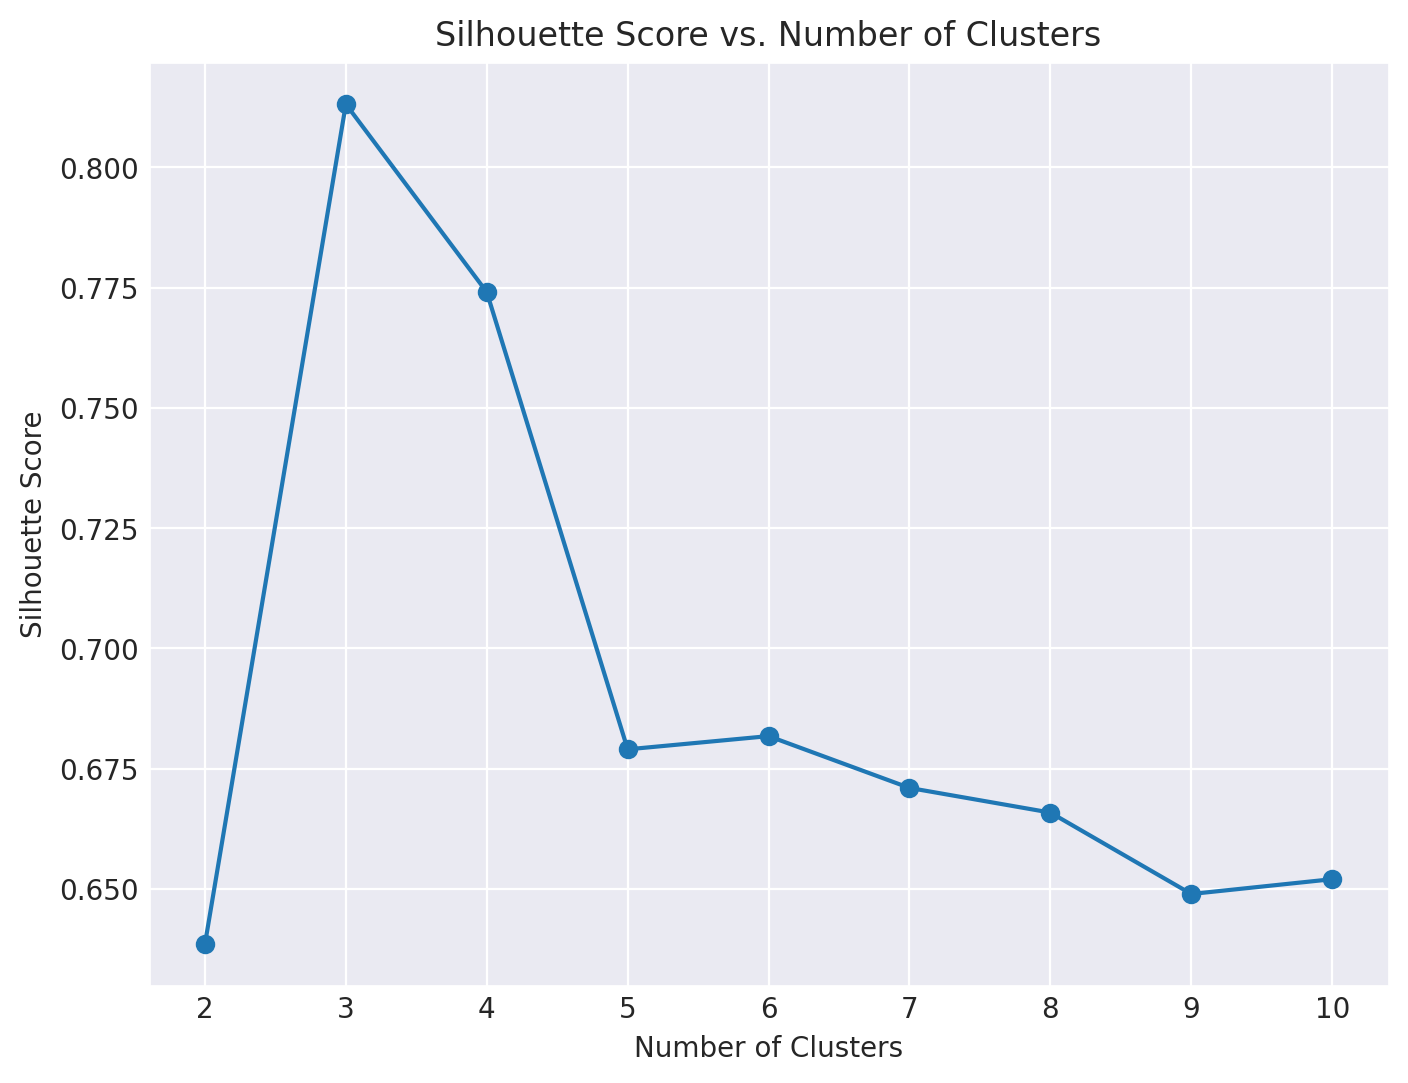

In [ ]:
# List to store silhouette values
silhouette_scores = []

# Range of number of clusters to try
cluster_range = range(2, 11)

# Calculate silhouette coefficient for each number of clusters
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    clusters = kmeans.fit_predict(glove_embedding_matrix_2d)
    silhouette_avg = silhouette_score(glove_embedding_matrix_2d, clusters)
    silhouette_scores.append(silhouette_avg)

# Find the optimal number of clusters that maximizes silhouette coefficient
optimal_n_clusters = cluster_range[np.argmax(silhouette_scores)]
max_silhouette_score = max(silhouette_scores)

print("Optimal number of clusters:", optimal_n_clusters)
print("Max silhouette score:", max_silhouette_score)

# Plot the results
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.show()


As the Silhouette score for 3 and 4 number of clusters is very similar lets see grafically which is the option more interestinig for us.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


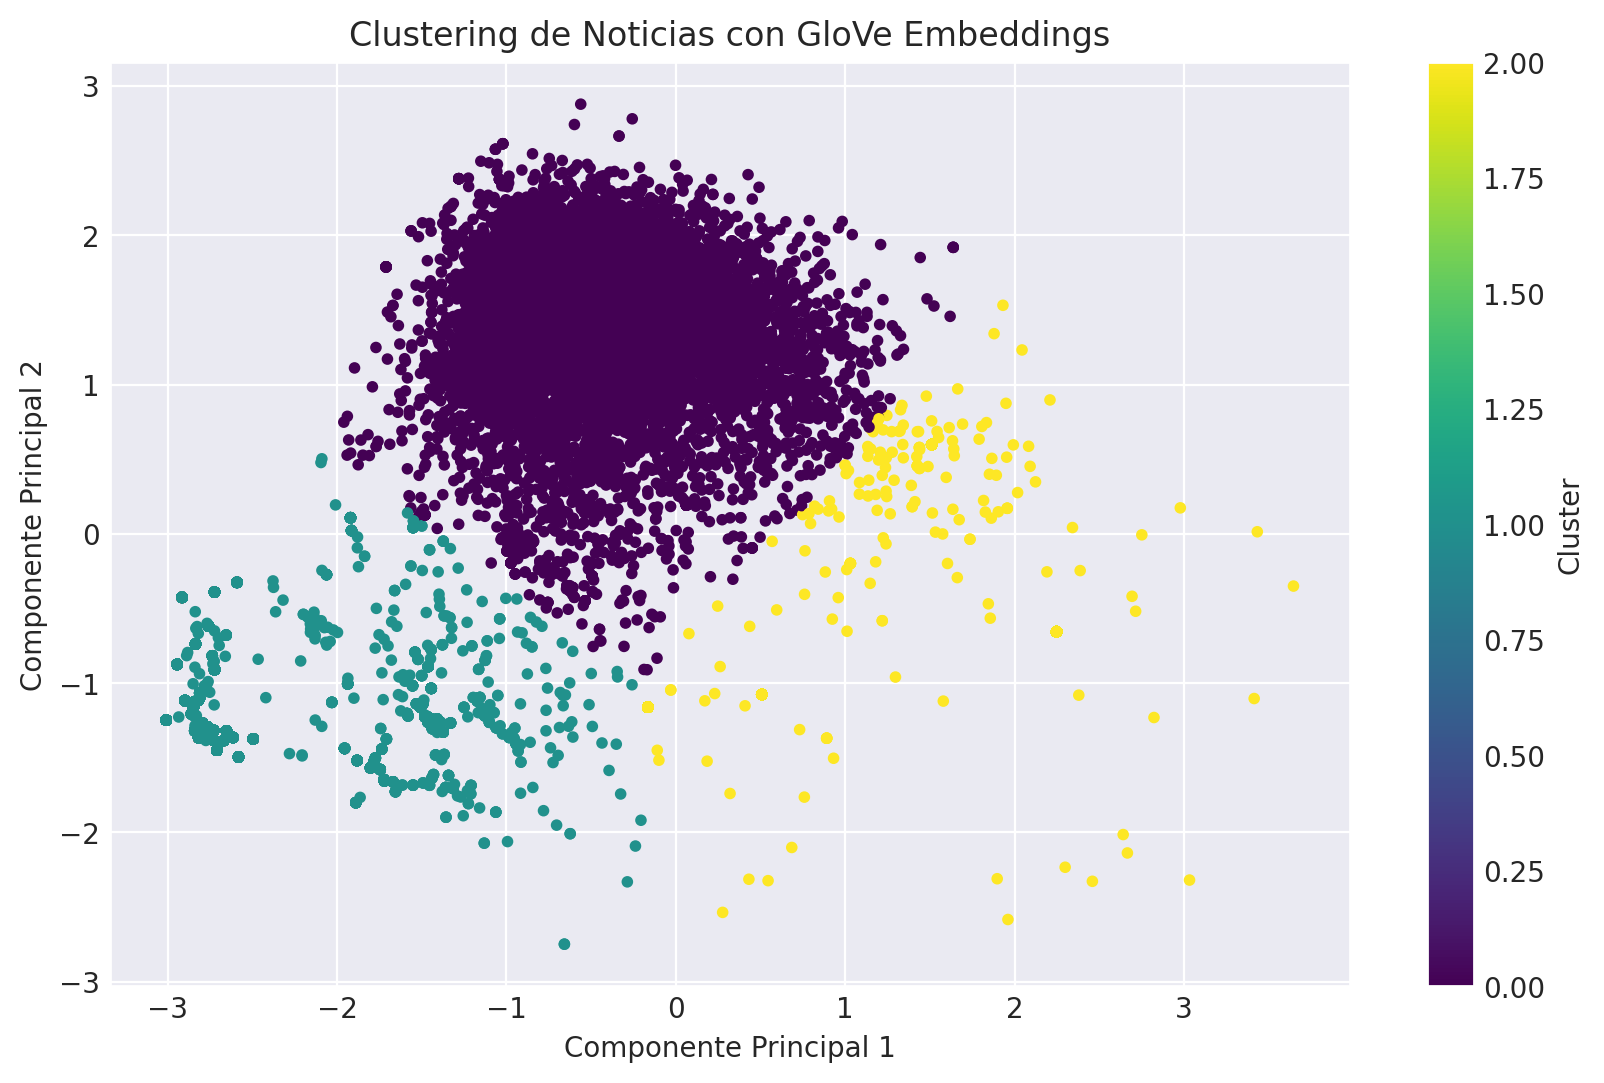

In [ ]:
#the original PCA had 3 clusters

plt.figure(figsize=(10, 6))
plt.scatter(glove_embedding_matrix_2d[:, 0], glove_embedding_matrix_2d[:, 1], c=clusters_glove, cmap='viridis', s=10)
plt.title('Clustering de Noticias con GloVe Embeddings')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


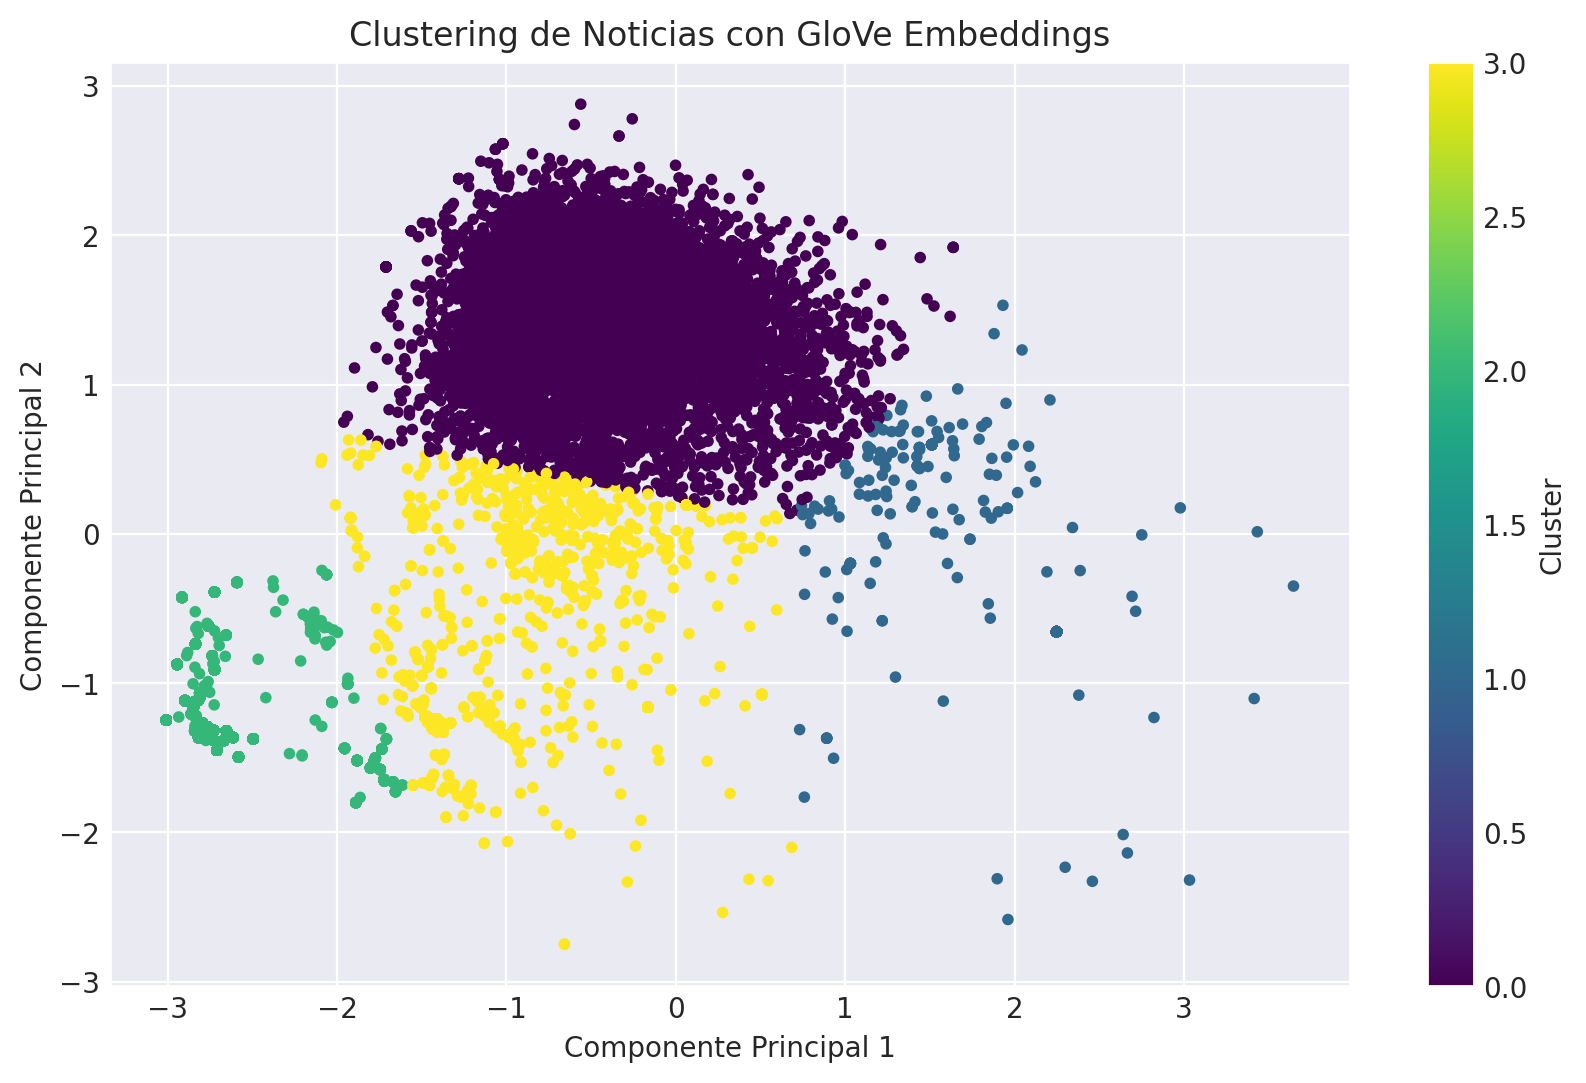

In [ ]:
# lets check for 4 clusters
kmeans = KMeans(n_clusters=4, random_state=42)
clusters_glove_4c = kmeans.fit_predict(glove_embedding_matrix_2d)

plt.figure(figsize=(10, 6))
plt.scatter(glove_embedding_matrix_2d[:, 0], glove_embedding_matrix_2d[:, 1], c=clusters_glove_4c, cmap='viridis', s=10)
plt.title('Clustering de Noticias con GloVe Embeddings')
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Cluster')
plt.show()

Now lets see if we can avoid doing such a drastic dimensionality reduction (from 50 to 2 dimensions) by previously selecting the meaningfull vectors of the embeddings (Feature Selection)

In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.model_selection import train_test_split
import numpy as np

# List to store silhouette scores for each number of dimensions
silhouette_scores = []

# Try different values of k for SelectKBest
for k in range(2, 50):  # Start from 2 to avoid errors with KMeans
    # Select top features using SelectKBest
    selector = SelectKBest(score_func=f_classif, k=k)
    X_train_selected = selector.fit_transform(glove_embedding_matrix, Y)

    # Train KMeans model with selected features
    kmeans = KMeans(n_clusters=3, random_state=42)
    kmeans.fit(X_train_selected)

    # Calculate silhouette score
    silhouette = silhouette_score(X_train_selected, kmeans.labels_)
    silhouette_scores.append((k, silhouette))

# Select the optimal number of dimensions with maximum silhouette score
optimal_k, optimal_silhouette = max(silhouette_scores, key=lambda x: x[1])
print("Optimal number of dimensions:", optimal_k)
print("Corresponding silhouette score:", optimal_silhouette)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init

Optimal number of dimensions: 2
Corresponding silhouette score: 0.6950198358106796


Lets check also with Random Forest that always give a good insight

In [ ]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(42)
# Build a forest and obtain the feature importances
forest = RandomForestRegressor(n_estimators=200)
forest.fit(glove_embedding_matrix, Y)
importances = forest.feature_importances_

# Obtain the positions of the sorted features (the most relevant first)
ind_rel_feat = np.argsort(importances)[::-1]

# Print the feature ranking
ranking_RF = pd.Series(importances[ind_rel_feat])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Text(0.5, 1.0, 'Ranking Glove dimensions with RF')

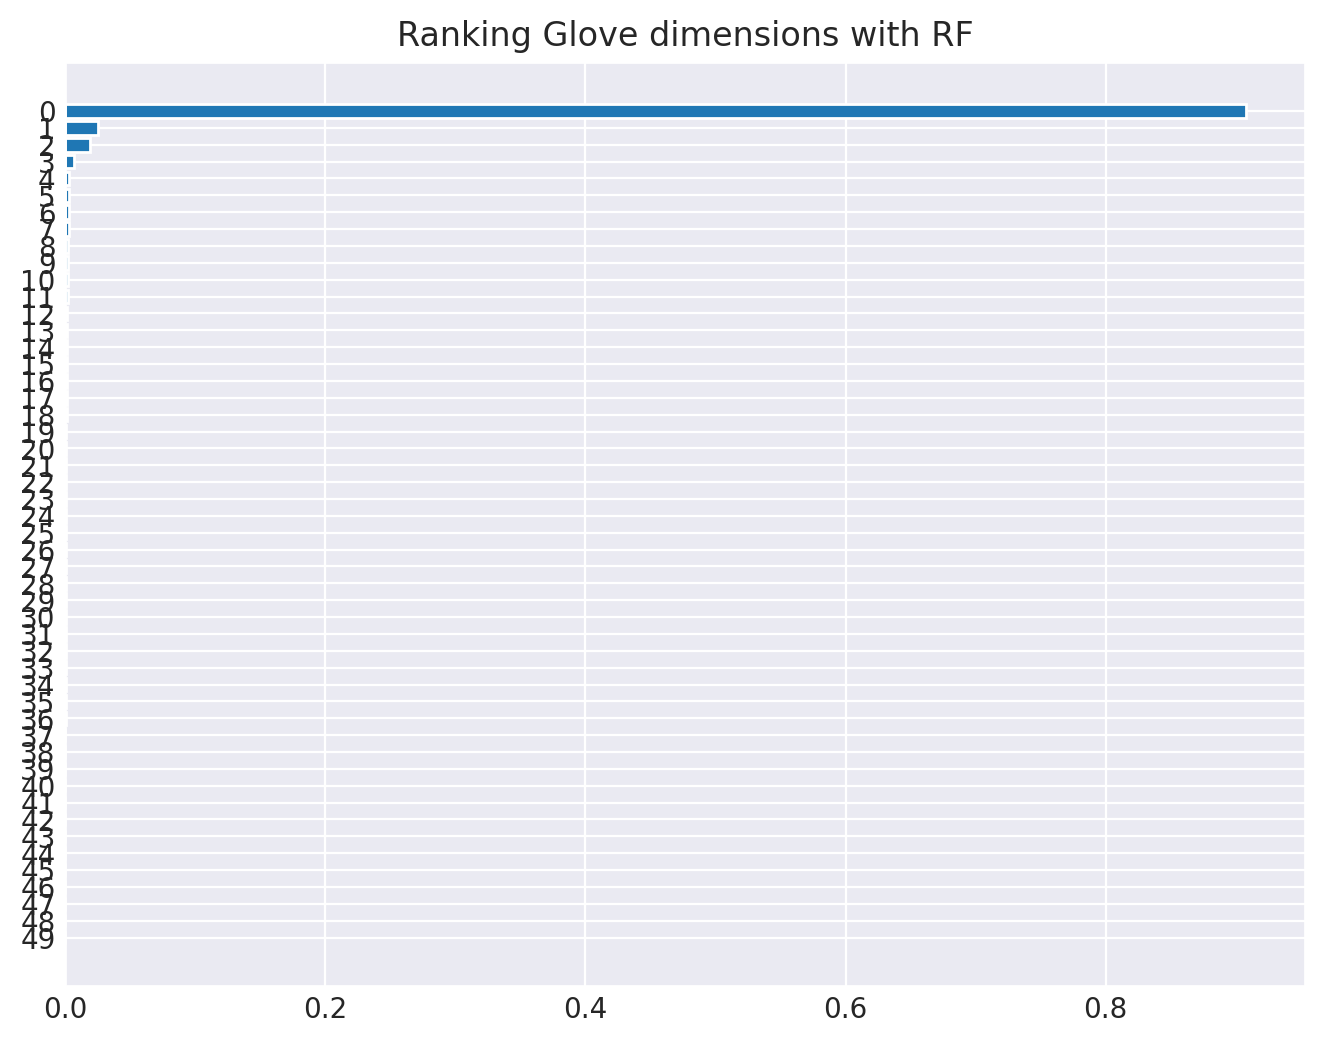

In [ ]:
y = ranking_RF.sort_values(ascending=True)
width = np.arange(len(y))
ticks = list(y.index)
plt.barh(width, y)
plt.yticks(width, ticks)
plt.title('Ranking Glove dimensions with RF')

In [ ]:
# Select only two dimensions from each vector of the GloVe embedding matrix
selector = SelectKBest(score_func=f_classif, k=2)
X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)

print("Shape of the selected feature matrix (training):", X_train_selected.shape)
print("Shape of the selected feature matrix (test):", X_test_selected.shape)


Shape of the selected feature matrix (training): (18200, 2)
Shape of the selected feature matrix (test): (7800, 2)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Initialize and fit the KMeans model with 3 clusters
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_train_selected)

# Predict clusters for training and test sets
train_clusters = kmeans.predict(X_train_selected)
test_clusters = kmeans.predict(X_test_selected)

# Print the centroids of the clusters
print("Centroids of the clusters:")
print(kmeans.cluster_centers_)

# Print the number of instances in each cluster for training and test sets
print("Number of instances in each cluster (training):")
print(np.bincount(train_clusters))
print("Number of instances in each cluster (test):")
print(np.bincount(test_clusters))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Centroids of the clusters:
[[-0.00235999  0.00080104]
 [-0.08837204  0.07566452]
 [-0.06142061  0.05199032]]
Number of instances in each cluster (training):
[10780  4114  3306]
Number of instances in each cluster (test):
[4639 1752 1409]


In our opinion making a selection of the embedding vectors of a document to represent it makes no sense. We decided at the beggining of the vectorization which was the best embedding size for each vectorization model, if we want to have less dimensions we can change it there. Erasing now embeddings make us lose the intuition of what we are doing and the reconstructions of the data have less sense and are less interpretable.

## Further Classification insights

We have seen that the best vectorization technique is Glove. We are going to explore its performance.

Firstly, as our accuracy is extrimely high, lets check that we are not overfitting our data:

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Precisión en conjunto de entrenamiento: 0.9983516483516484
Precisión en conjunto de prueba: 0.9969230769230769


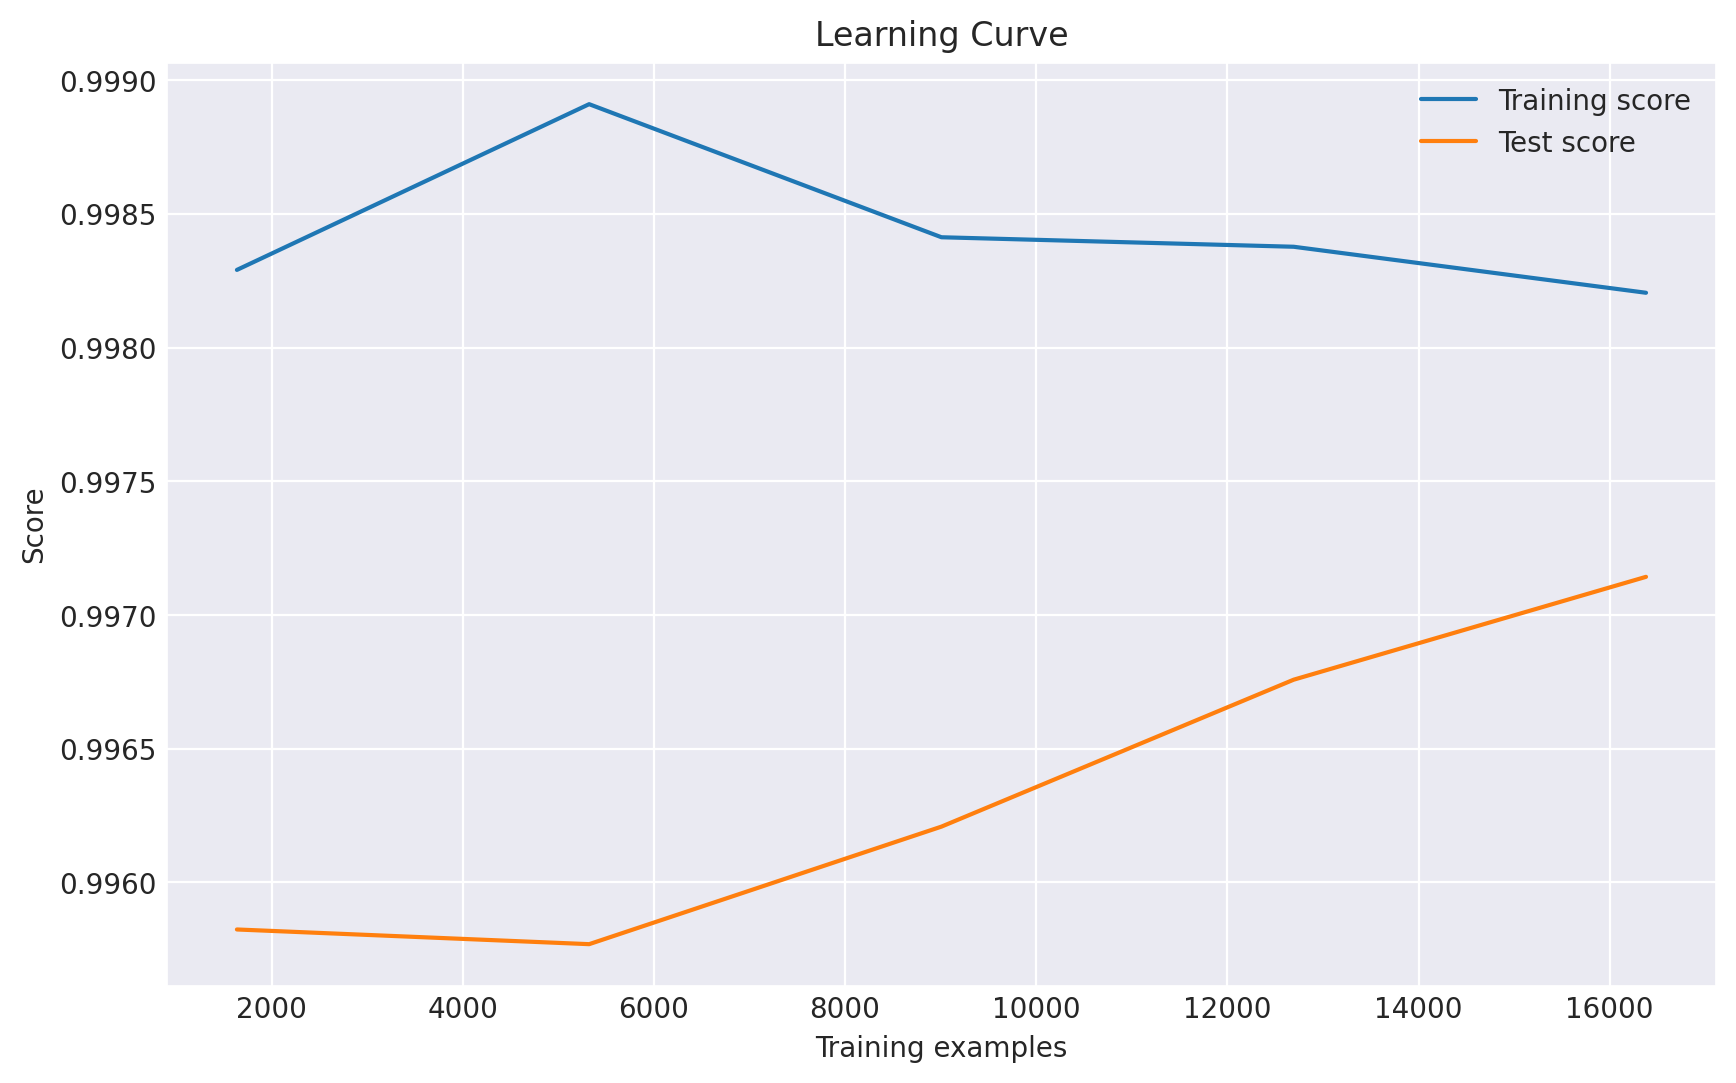

In [ ]:
from sklearn.model_selection import learning_curve

y_pred_train = svm_best_glove.predict(X_train_glove)
accuracy_train = accuracy_score(y_train_glove, y_pred_train)

y_pred_test = svm_best_glove.predict(X_test_glove)
accuracy_test = accuracy_score(y_test_glove, y_pred_test)

print("Precisión en conjunto de entrenamiento:", accuracy_train)
print("Precisión en conjunto de prueba:", accuracy_test)

train_sizes, train_scores, test_scores = learning_curve(
    svm_best_glove, X_train_glove, y_train_glove, cv=10, scoring='accuracy')

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Test score')
plt.title('Learning Curve')
plt.xlabel('Training examples')
plt.ylabel('Score')
plt.legend()
plt.show()


The performance is similar in both datasets, so it does not seem that we are overfitting

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


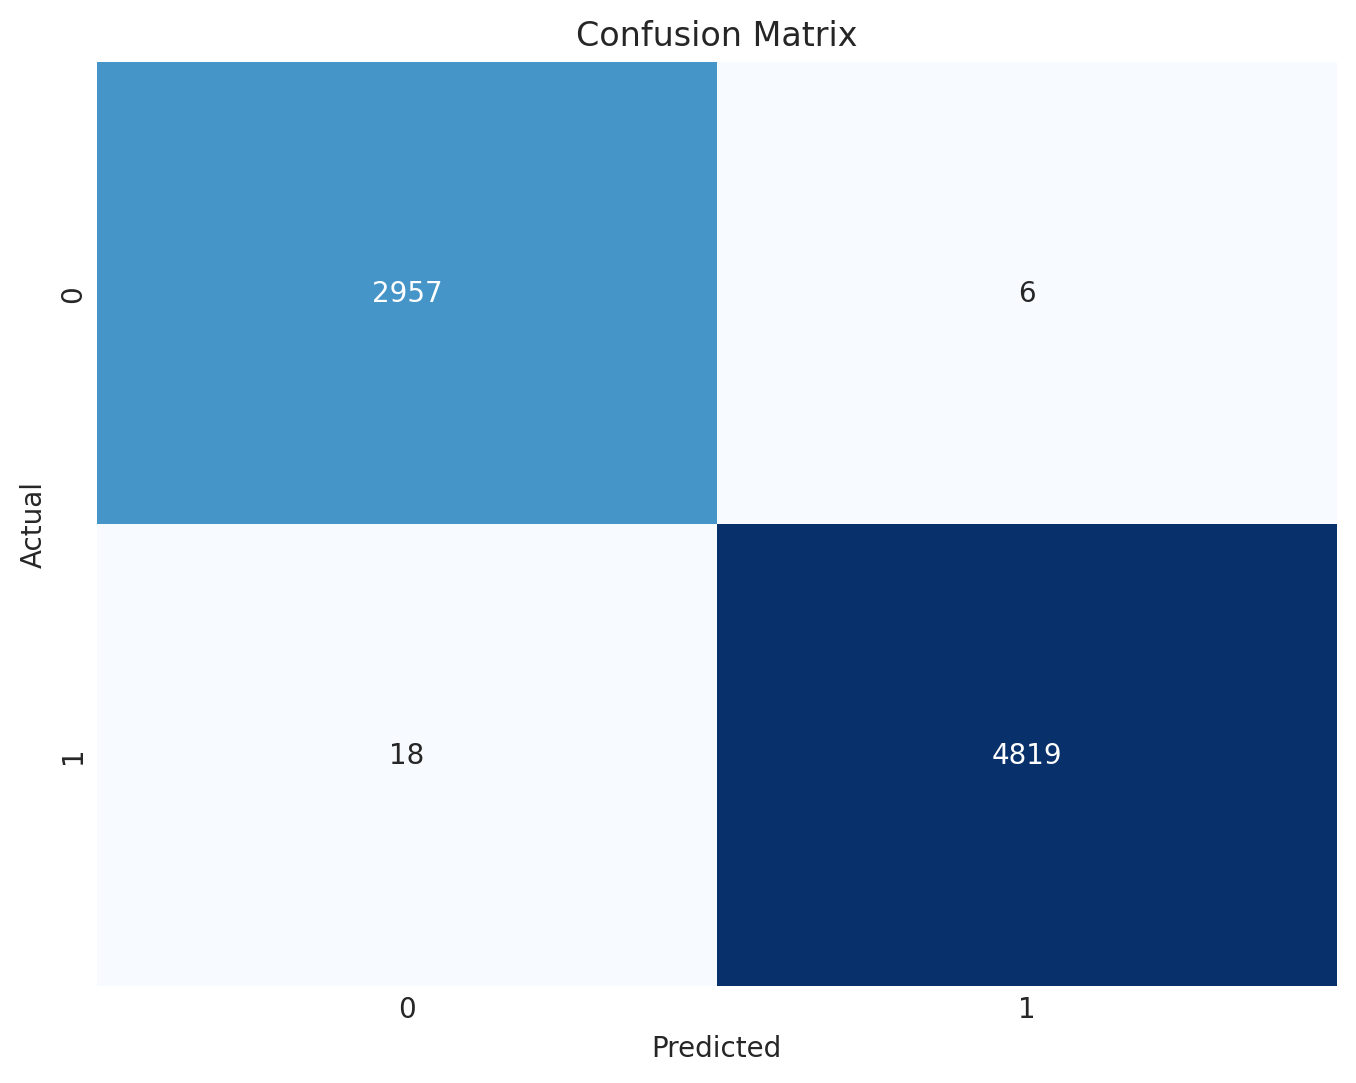

In [ ]:
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc
import matplotlib.pyplot as plt

# Matriz de Confusión
conf_matrix = confusion_matrix(y_test_glove, y_pred_glove)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


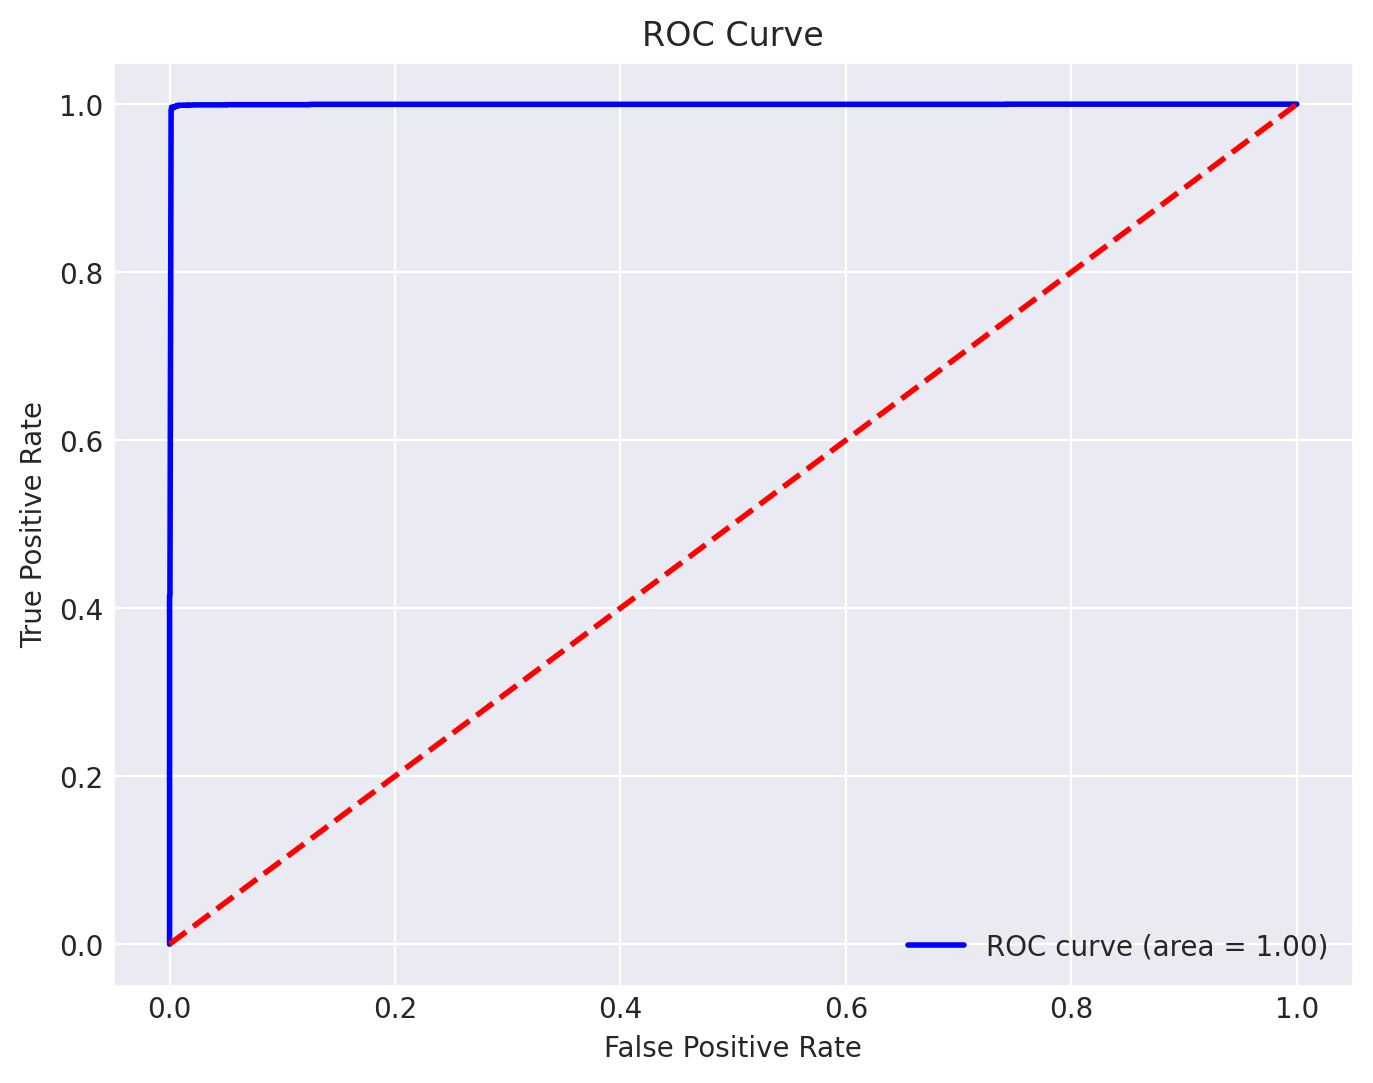

AUC ROC for SVM is 0.9992686312219112


In [ ]:
# Curva ROC
from sklearn import metrics
y_score_glove = svm_best_glove.decision_function(X_test_glove)
fpr, tpr, _ = roc_curve(y_test_glove, y_score_glove)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Compute area under ROC curve
area_roc_SVM = metrics.roc_auc_score(y_test_glove, y_score_glove)

print(f"AUC ROC for SVM is {area_roc_SVM}")

We are going to try with a Random Forest model to check if the SVM overfits and also to try a different model and see its result. However, now we are very confident that we are not overfitting and what we have is a very good model, thanks primarly to the vectorization of glove, which we have seen on clustering that is able to make a very good separation of clickbait and non-clickbait.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer

# Supongamos que tienes tus datos de texto en X_train_text y X_test_text, y las etiquetas correspondientes en y_train y y_test

X_train, X_test, y_train, y_test = train_test_split(glove_embedding_matrix, Y, test_size=0.3, random_state=42)

# Definir los parámetros a explorar
param_grid = {
    'n_estimators': [50, 100, 150],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Inicializar el clasificador Random Forest
rf_classifier = RandomForestClassifier(random_state=42)

# Inicializar GridSearchCV
grid_search = GridSearchCV(estimator=rf_classifier, param_grid=param_grid, cv=5, scoring='accuracy')

# Entrenar GridSearchCV
grid_search.fit(X_train, y_train)

# Obtener los mejores hiperparámetros
best_params = grid_search.best_params_
print("Best parameters:", best_params)

# Obtener el mejor estimador
best_rf = grid_search.best_estimator_

# Predecir las etiquetas en el conjunto de prueba
y_pred = best_rf.predict(X_test)

# Calcular la precisión del modelo
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Best parameters: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Accuracy: 0.9956410256410256


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


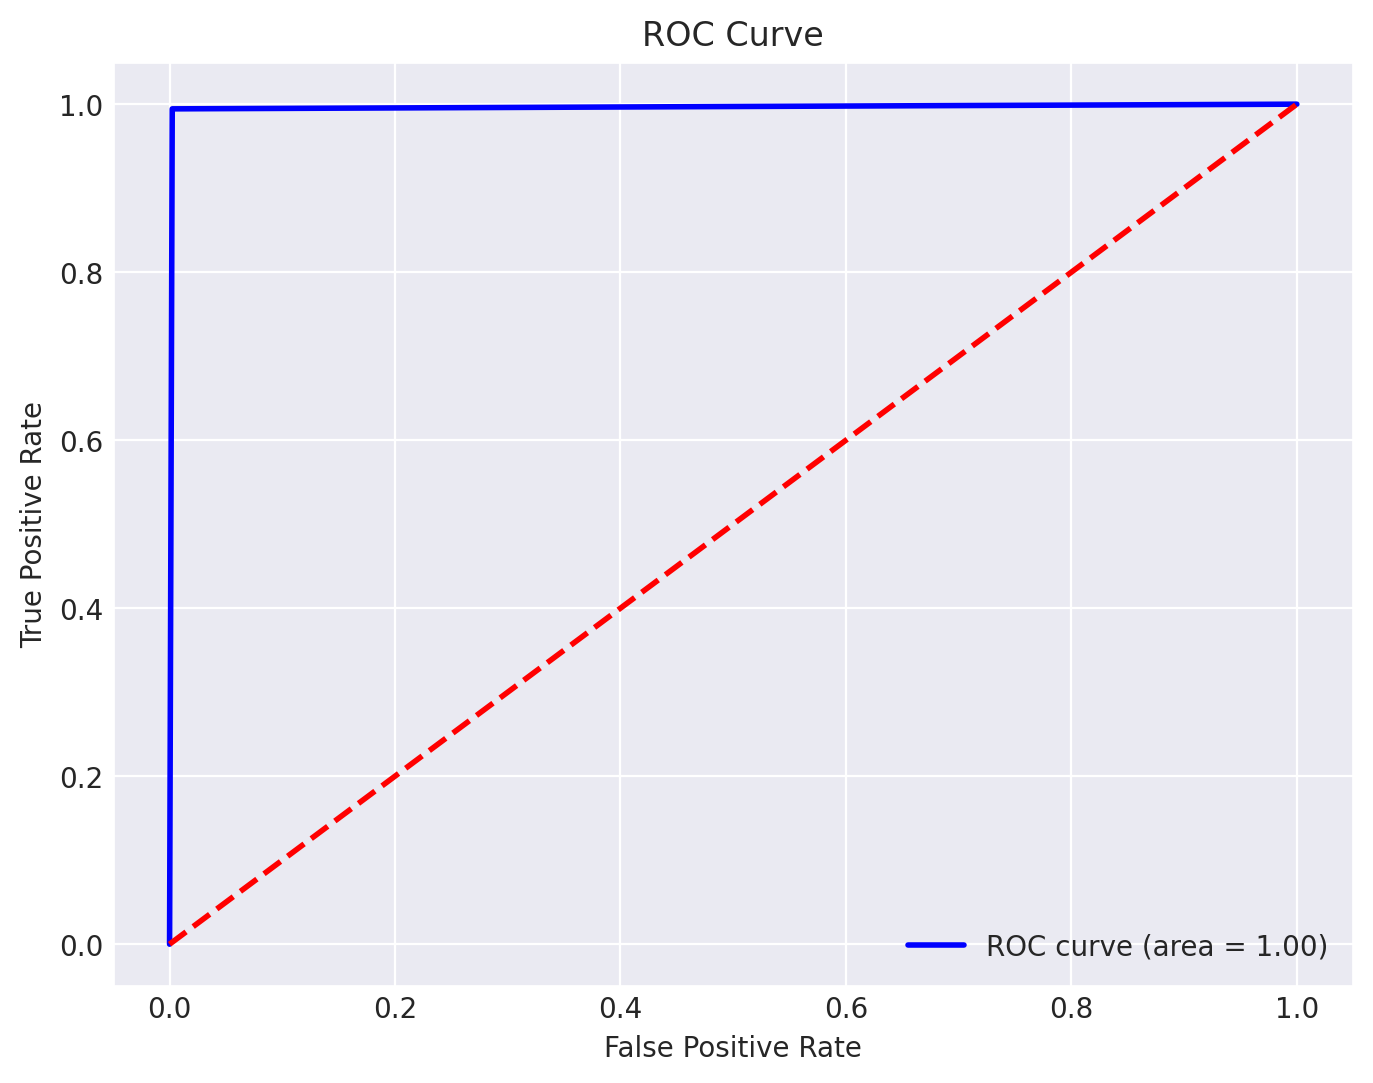

AUC ROC for RF is 0.9960277786170014


In [ ]:
y_score = best_rf.predict(X_test)
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()

# Compute area under ROC curve
area_roc_SVM = metrics.roc_auc_score(y_test, y_score)

print(f"AUC ROC for RF is {area_roc_SVM}")

With a random forest we also obtain a very high accuracy wo we do not think that we are overfitting the training data.

We see that with a simple Ml model such an SVM we obtain an incredibly accuracy (even slightly better than with RF, probably thanks to the distribution obtained with glove as seen in the clustering part)  when classifying clickbait and non-clickbait news. This makes sense with the intuitions we obtained from the clustering part. Because of this, we think that this model is effective enough and making a more complex model such a recurrent neural network is not necessary.

## News Recommender Systems

Our database does not contain any information that we can use for recommender systems, so we are going to create it.
We are going to simulate 10000 users ids that have given like or not to the news, and store at each row the ids of the users that have given like to that title.

In [ ]:
import random

# Reset the DataFrame index and add a new column for the news ID
corpus_df.reset_index(drop=True, inplace=True)
corpus_df['news_id'] = corpus_df.index + 1  # Add 1 so that IDs start from 1 instead of 0

num_users = 10000
user_ids = list(range(1, num_users + 1))

# Assign random users to news and record which news each user likes
users_liked_dict = {}

media_clickbait = 5
desviacion_clickbait = 2
media_no_clickbait = 15
desviacion_no_clickbait = 5

def assign_users(news_id):
    is_clickbait = corpus_df.loc[corpus_df['news_id'] == news_id, 'is_clickbait'].iloc[0]
    # Generate random numbers with normal distribution
    if is_clickbait == 1:
        num_liked = int(np.random.normal(media_clickbait, desviacion_clickbait))
        # Ensure number of likes is not negative
        num_liked = max(num_liked, 1)
    elif is_clickbait == 0:
        num_liked = int(np.random.normal(media_no_clickbait, desviacion_no_clickbait))
        # Ensure number of likes is not negative
        num_liked = max(num_liked, 1)

    # Assign random users who liked the news
    liked_users = random.sample(user_ids, num_liked)
    for user_id in liked_users:
        if user_id not in users_liked_dict:
            users_liked_dict[user_id] = [news_id]
        else:
            users_liked_dict[user_id].append(news_id)
    return liked_users

# Apply the function to each row of your DataFrame
corpus_df['users_liked_titles'] = corpus_df['news_id'].apply(assign_users)
# Add a column counting the number of users who liked each news
corpus_df['num_likes'] = corpus_df['users_liked_titles'].apply(lambda x: len(x))

# Create a DataFrame to record which news each user likes
user_preferences_data = [{'user_id': user_id, 'liked_news': liked_news} for user_id, liked_news in users_liked_dict.items()]
user_preferences_df = pd.DataFrame(user_preferences_data)

display(corpus_df.head())
display(user_preferences_df.head())


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,text,processed_text,is_clickbait,news_id,users_liked_titles,num_likes
0,Honey Boo Boo Walking Through Beverly Hills Is...,"[honey_boo, boo, walking, beverly_hill, honey_...",1,1,"[1926, 3601, 65, 5196, 1035, 7378, 3375]",7
1,If I Could Speak To My Mental Disorder,"[could, speak, mental, disorder]",1,2,"[7417, 6503, 8301, 7982]",4
2,Memphis Uses Size and Speed to Overpower Maryl...,"[memphis, us, size, speed, overpower, maryland...",0,3,[9592],1
3,How Futuristic Are You,[futuristic],1,4,"[3981, 6171, 860, 463, 1707]",5
4,"Welsh air route in difficulties, call for fund...","[welsh, air, route, difficulty, call, funding_...",0,5,"[908, 4379, 1820, 6054, 6174, 6400, 6455, 598,...",13


,user_id,liked_news
0,1926,"[1, 515, 1525, 2050, 3591, 3833, 3841, 4135, 6..."
1,3601,"[1, 1693, 2989, 5906, 7212, 7646, 9777, 11176,..."
2,65,"[1, 2197, 2268, 2406, 2861, 2963, 7937, 8185, ..."
3,5196,"[1, 1699, 2090, 2240, 3227, 4692, 4728, 4992, ..."
4,1035,"[1, 615, 1015, 1174, 2900, 4532, 5577, 7034, 7..."


### Popularity-based recommendation system

As explain in the report, the above intuition has several difficulties. However we can still generate some recommendation systems. A very easy one is to show the most-liked news, by simply counting the number of users that have givven like to each news.

In [ ]:
popularity_df = corpus_df.sort_values(ascending=False,by=['num_likes'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### Content-based recommendation system

A better and more sophisticated one would consider the news that a user has given like and recomend similar news to those ones.

Of course we are going to use the glove embedding vectors from allthe others that we have analized previously because they were the ones that captured better the context and using less embedding size.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity

# Function to recommend news similar to those liked by a given user
def recommend_similar_news(user_id, glove_embedding_matrix, user_preferences_df, corpus_df, top_n=5):
    # Get the news liked by the user
    liked_news = user_preferences_df.loc[user_preferences_df['user_id'] == user_id, 'liked_news'].iloc[0]

    # Calculate the mean representation of the news liked by the user
    liked_news_embeddings = [glove_embedding_matrix[news_index-1] for news_index in liked_news]
    mean_embedding = np.mean(liked_news_embeddings, axis=0)

    # Calculate the similarity between the mean representation and all other news
    similarity_scores = cosine_similarity([mean_embedding], glove_embedding_matrix)[0]

    # Get the indices of news sorted by descending similarity
    sorted_indices = similarity_scores.argsort()[::-1]

    # Filter out the news that the user hasn't seen yet
    unseen_news_indices = [idx for idx in sorted_indices if idx not in liked_news]

    # Select the top_n news with highest similarity to the mean
    recommended_indices = unseen_news_indices[:top_n]

    # Get the titles of the recommended news
    recommended_news = corpus_df.iloc[recommended_indices]['text'].tolist()

    return recommended_news

# Example recommendation for a given user
user_id = 122  # Suppose we want to recommend news to the user with ID 122
recommended_news = recommend_similar_news(user_id, glove_embedding_matrix, user_preferences_df, corpus_df)
print("Recommended news for user", user_id, ":")
print(len(recommended_news))
print(recommended_news)


Recommended news for user 122 :
5
['Breeding Penguin Couples Stay Close in a Crowd\nBehind the Profits Lies Trouble for 2 Bank Giants\nMark Latham in fight 12 months after resigning as Australian opposition leader', "Obama Faces Pressure to Strike Firmer Tone on Iran\nA Ham Radio Weekend for Talking to the Moon\nRelease of Russian Who Killed Chechen Woman Stokes Tensions\nMusic Producer Draws Term of 19 Years to Life for Killing\n'Killing Fields' trial for S-21 chief Duch underway in Cambodia", 'California Names Its Top Income Tax Scofflaws\nEuropeans Debate Castration of Sex Offenders\nU.S. Moves Against Top Mexican Drug Cartel\nUnprecedented review to be held on Qantas after third emergency in two weeks', 'At Least 23 Die in Bombing in Lahore, Pakistan\nJordanian king dissolves parliament, calls for general election two years ahead of schedule', 'Republicans in Senate Lower Expectations of a Court Fight\nLeading Figure, Defiant, Re-Emerges in Stanford Case\nFate of Missing Iraqis Hau

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
